# COVID-19 Data Analyses using Johns Hopkins Data

Note: The most up-to-date version of this notebook can be found in GitHub repository [bmc/covid19][].

The primary data source for this notebook is the Johns Hopkins University's Center for Systems Science and Engineering (CSSE) 
[COVID-19 data repository](https://github.com/CSSEGISandData/COVID-19).

For additional data sources used, see [the README](https://github.com/bmc/covid19/blob/master/README.md)
in [bmc/covid19].

## Approach

This notebook loads the Johns Hopkins COVID-19 CSV files into a [Pandas](https://pandas.pydata.org/) DataFrame. It
then manipulates, queries, and plots the DataFrame.

[**I don't want to look at code. Take me to the first graph!**](#United-States)

[bmc/covid19]: https://github.com/bmc/covid19/

## Imports and constants

In [1]:
import matplotlib
import matplotlib.pyplot as p
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, date
import csv
import os
import sys
import re
import math
from pprint import pprint
from enum import Enum
from itertools import chain
from lib.common import *

print(f"Using Python {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")
print(f"Using matplotlib {matplotlib.__version__}")
print(f"Using Pandas {pd.__version__}")

Using Python 3.8.4
Using matplotlib 3.2.2
Using Pandas 1.0.5


In [2]:
JOHNS_HOPKINS_DIR_PATH = 'data/johns-hopkins/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us'
SOURCE = "Johns Hopkins University Center for Systems Science and Engineering (CSSE)"

In [3]:
os.makedirs(IMAGES_PATH, exist_ok=True)
today = datetime.now().date()

## Helpers

In [4]:
def make_month_day_column(df):
    df[COL_MONTH_DAY] = df[COL_DATE].dt.strftime('%m/%d')

# Read the data into a single Pandas DataFrame
def read_all_into_pandas():
    """
    Read all CSV files into a single Pandas DataFrame, normalizing
    the column names and discarding the ones we don't want.
    
    The DataFrame will be sorted by date.
    """
    f_pat = re.compile(r'^([01]\d-[0123]\d-202\d)\.csv')
    data_frames = []
    for f in os.listdir(JOHNS_HOPKINS_DIR_PATH):
        # Skip any file that doesn't match the regex. It'd
        # probably be sufficient to check the extension, but
        # this approach is more robust.
        m = f_pat.match(f)
        if m is None:
            continue
        df = pd.read_csv(os.path.join(JOHNS_HOPKINS_DIR_PATH, f))
        df['Date'] = m.group(1)
        # Now, convert to Pandas datetime. You can't store a regular
        # Python date or datetime in Pandas and then operate on it
        # using Pandas datetime functions. It has to be a Pandas
        # datetime.
        df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%Y')
        data_frames.append(df[[
            'Date', 'Province_State', 'Confirmed', 'Deaths', 'Recovered',
            'People_Tested', 'People_Hospitalized'
        ]])

    df2 = pd.concat(data_frames, ignore_index=True)

    final_df = df2.rename(columns={
        'Province_State':      COL_REGION,
        'Date':                COL_DATE,
        'Deaths':              COL_DEATHS,
        'People_Tested':       COL_TESTS,
        'Confirmed':           COL_CASES,
        'Recovered':           COL_RECOVERIES,
        'People_Hospitalized': COL_HOSPITALIZATIONS
    })

    for col in (COL_DEATHS, COL_CASES, COL_TESTS, COL_RECOVERIES, COL_HOSPITALIZATIONS):
        final_df[col] = final_df[col].fillna(0)

    final_df = final_df.astype({
        COL_DEATHS: int,
        COL_CASES: int,
        COL_HOSPITALIZATIONS: int,
        COL_RECOVERIES: int,
        COL_TESTS: int
    })

    make_month_day_column(final_df)

    final_df.sort_values(by=[COL_DATE], inplace=True)
    return final_df

## Read the data

### Load the state population data

In [5]:
populations = load_united_states_population_data()
print(f"{populations['United States']:,}")

334,351,340


### Load the Johns Hopkins data

In [6]:
df = read_all_into_pandas()

In [7]:
df

date          region  cases  deaths  recoveries   tests  \
2413 2020-04-12     Mississippi   2781      96           0   21413   
2412 2020-04-12       Minnesota   1621      70         842   37421   
2411 2020-04-12        Michigan  24244    1479         433   79437   
2410 2020-04-12   Massachusetts  25475     756           0  116730   
2409 2020-04-12        Maryland   8225     236         456   49764   
...         ...             ...    ...     ...         ...     ...   
5843 2020-08-07       Minnesota  59185    1681       51940  910271   
5844 2020-08-07     Mississippi  65436    1848       42391  487212   
5845 2020-08-07        Missouri  57837    1324           0  752740   
5832 2020-08-07           Idaho  23925     229        8486  198700   
5862 2020-08-07  South Carolina  98219    1962       37798  767961   

      hospitalizations month_day  
2413               548     04/12  
2412               361     04/12  
2411              3636     04/12  
2410              2235     04/12  
2409              1860     04/12  
...                ...       ...  
5843              5458     08/07  
5844              4577     08/07  
5845                 0     08/07  
5832               954     08/07  
5862              6153     08/07  

[6862 rows x 8 columns]

In [8]:
jhu_starting_date = df.date.min().date()
jhu_ending_date = df.date.max().date()
# See https://stackoverflow.com/a/15411596
total_unique_dates = len(df.groupby('date').date.nunique())
print(f"Loaded data for {total_unique_dates} weeks.")
# len(dataframe.index) is the idiom for getting the number of rows.
print(f"Total rows: {len(df.index):,}")
print(f"Starting date: {datestr(jhu_starting_date, include_year=True)}")
print(f"Ending date: {datestr(jhu_ending_date, include_year=True)}")

Loaded data for 118 weeks.
Total rows: 6,862
Starting date: 04/12/2020
Ending date: 08/07/2020


## Deaths and cases in a single region

### United States

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50d3d8be0>)

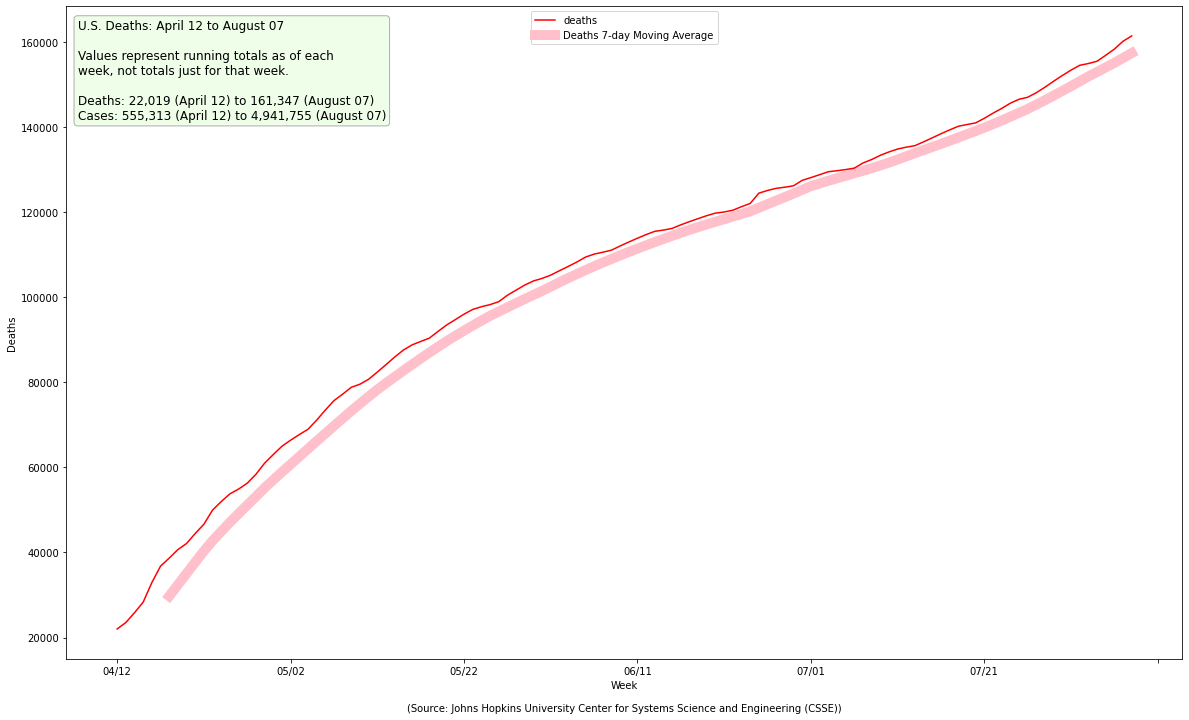

In [9]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS}, moving_average=True,
                   image_file='jhu-us-deaths.png', textbox_heading="U.S. Deaths")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50b1d2b20>)

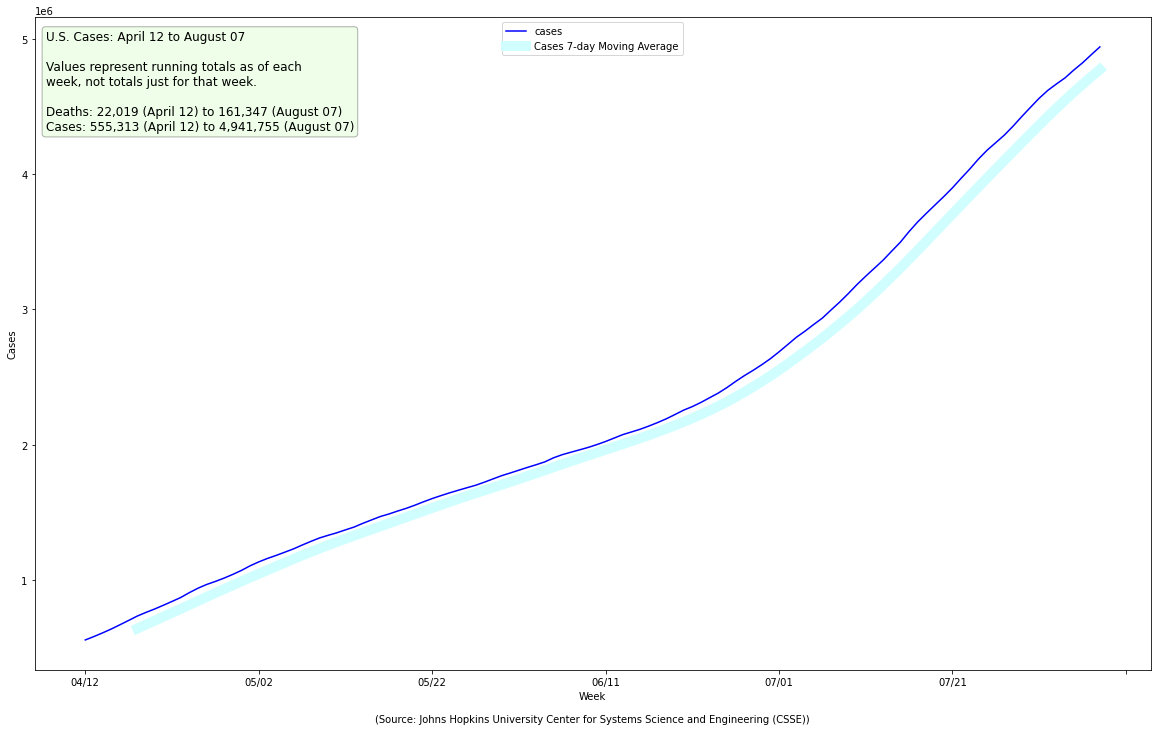

In [10]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.CASES}, moving_average=True,
                   image_file='jhu-us-cases.png', textbox_heading="U.S. Cases")

#### Positivity Rate

The positivity rate is problematic. At the beginning of the pandemic,
we weren't testing much at all, and the tests were reserved largely
for those showing symptoms. So the positivity rate was, not surprisingly,
quite high. It will have declined over time, because we're testing more
of the population, including more people who come up negative.

Rather than plot the positivity rate since April, which is somewhat
misleading, just plot the positivity rate for the last 45 days.

**Note**: A drop-off toward the end isn't necessarily cause for celebration.
Reporting of cases probably lags.

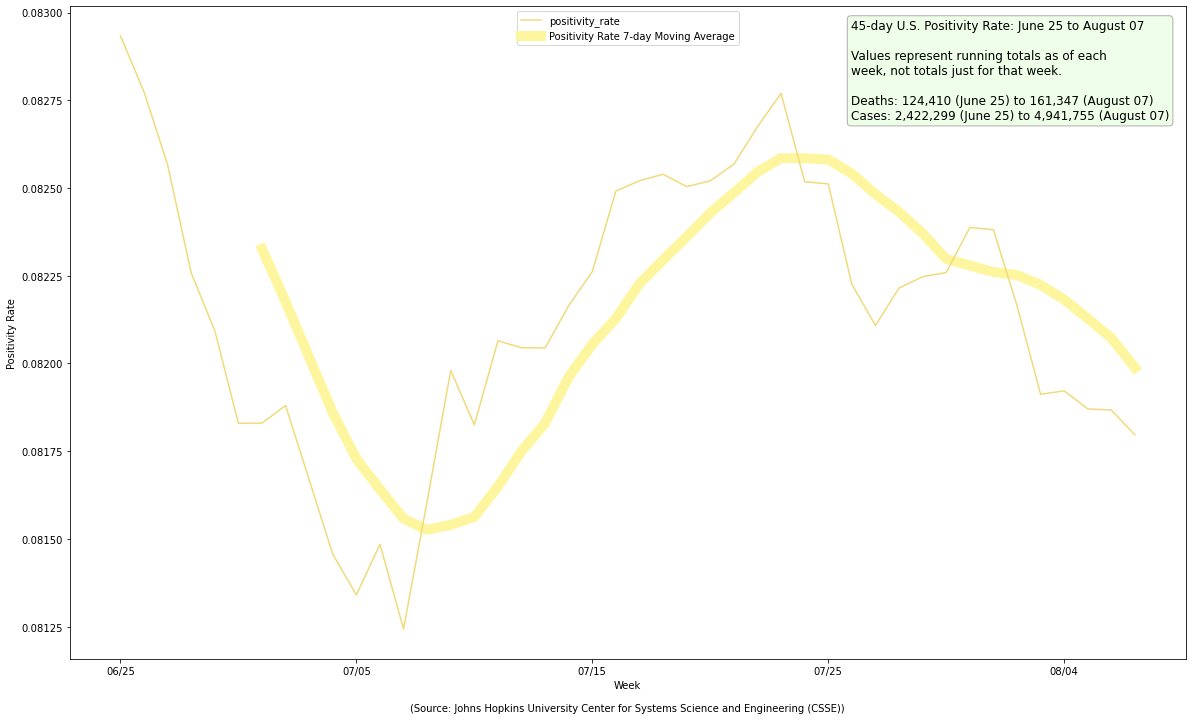

In [11]:
delta = timedelta(days=45)
cutoff = date_to_datetime(today - delta)
df_positivity_dates = df.loc[df.date >= cutoff]
fig, ax = plot_stats_by_date(df_positivity_dates, SOURCE, metrics={MetricType.POSITIVITY},
                             image_file='jhu-us-positivity-rate.png', 
                             textbox_heading="45-day U.S. Positivity Rate",
                             textbox_loc=(0.7, 0.98),
                             moving_average=True)

#### Daily values, instead of cumulative values

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50b149d00>)

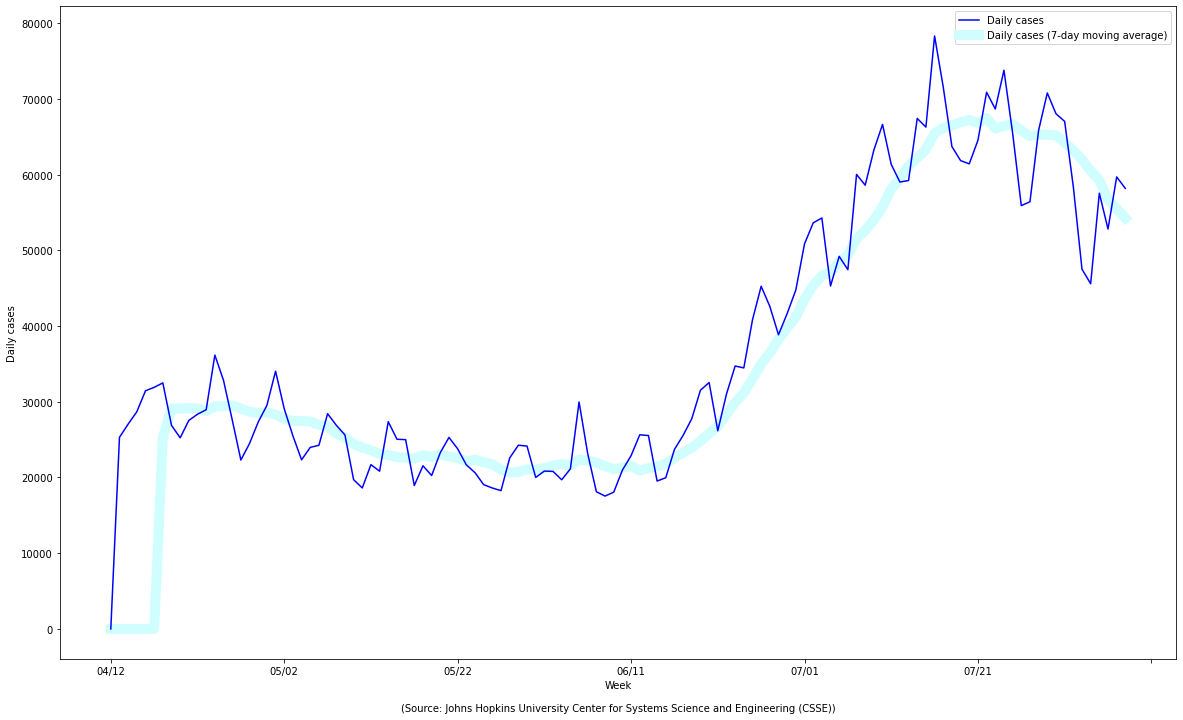

In [12]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50af68e20>)

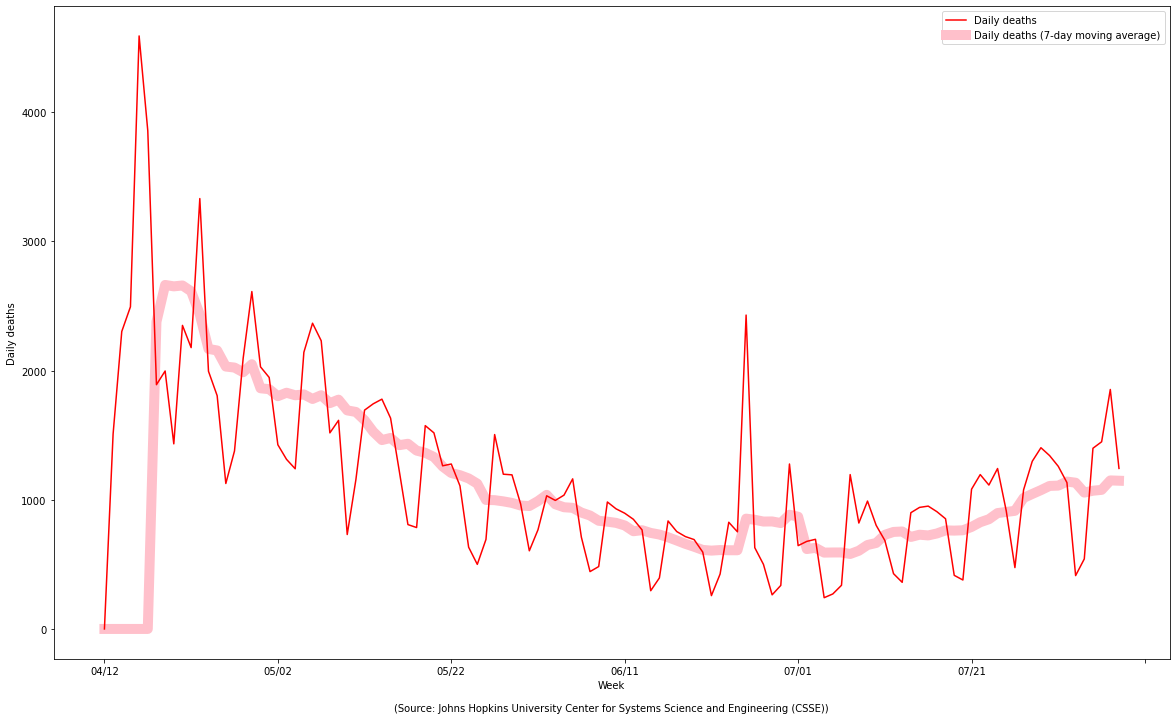

In [13]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='United States',
                 moving_average=True,
                 image_file="jhu-us-deaths-daily.png")

#### Just the past week

In [14]:
week_delta = timedelta(days=6)
six_days_prior = jhu_ending_date - week_delta
last_week_start = date_to_datetime(six_days_prior)
last_week_end = date_to_datetime(jhu_ending_date, hour=23, minute=59, second=59)

df_past_week = df.loc[(df[COL_DATE] >= last_week_start) & (df[COL_DATE] <= last_week_end)]

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50af544c0>)

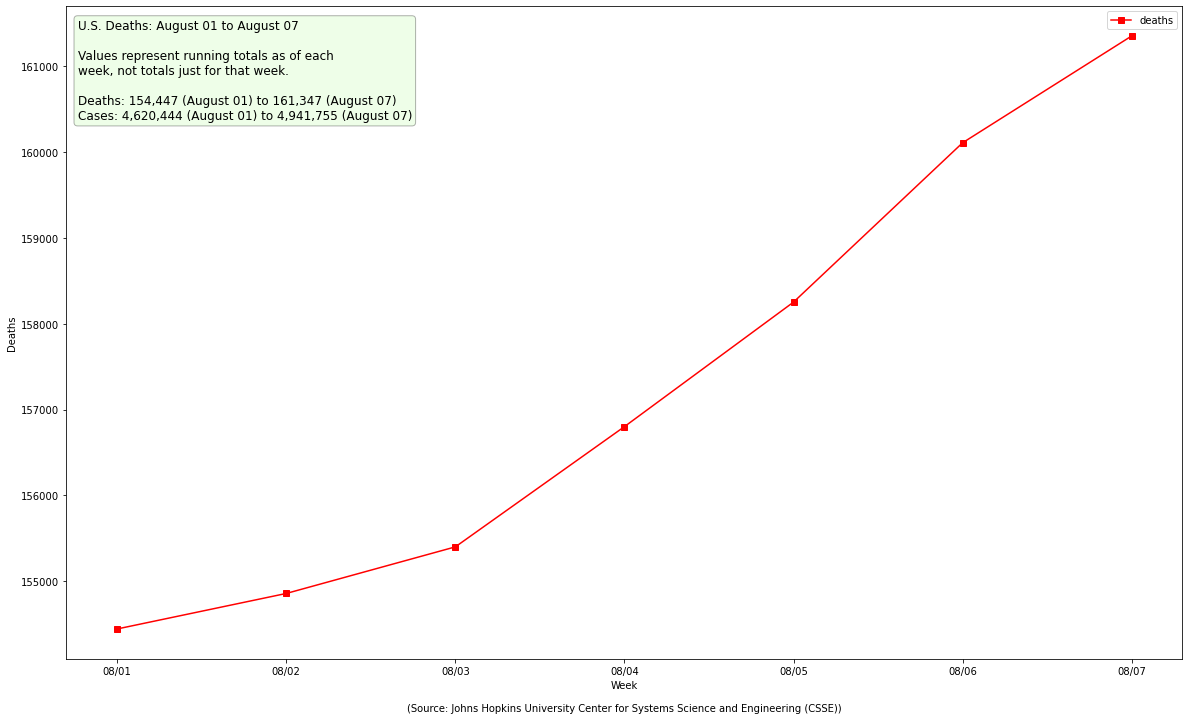

In [15]:
plot_stats_by_date(df_past_week, SOURCE, metrics={MetricType.DEATHS}, marker='s', 
                   textbox_heading="U.S. Deaths", image_file='jhu-us-deaths-past-week.png')

#### Deaths vs. Cases

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50afe1e50>)

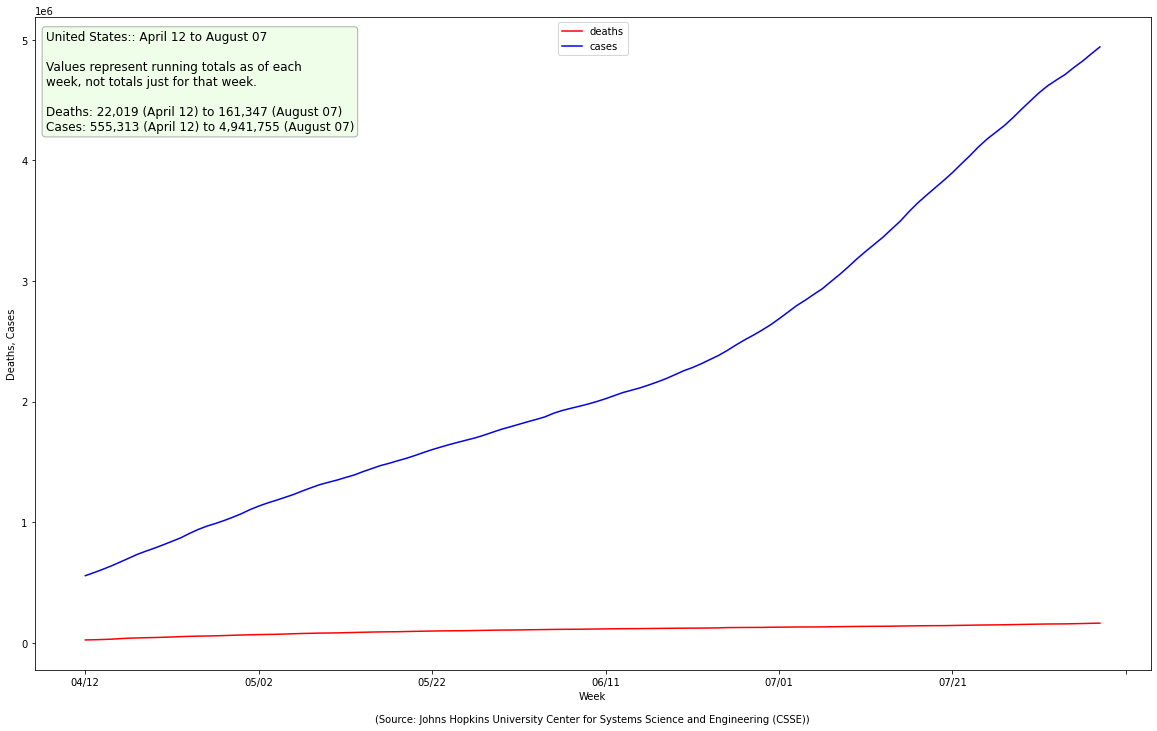

In [16]:
plot_stats_by_date(df, SOURCE, metrics={MetricType.DEATHS, MetricType.CASES}, 
                   textbox_heading="United States:", image_file="jhu-us-deaths-and-cases.png")

### Individual States

#### Pennsylvania

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50ae85910>)

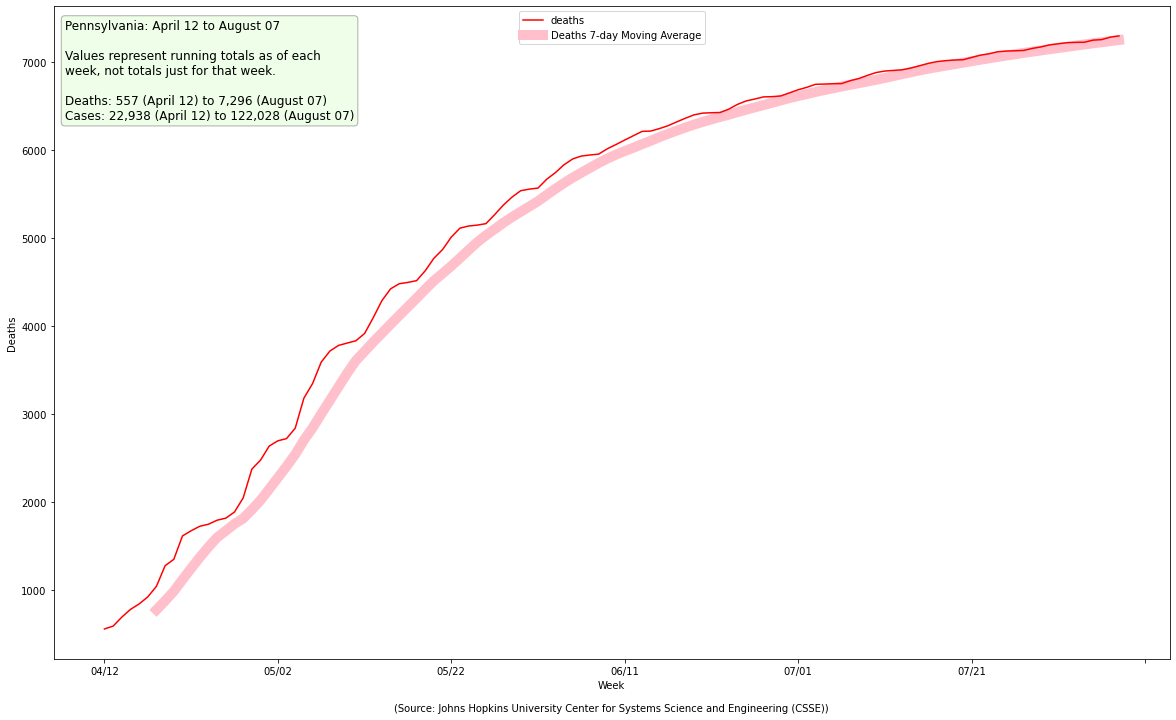

In [17]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50ae298b0>)

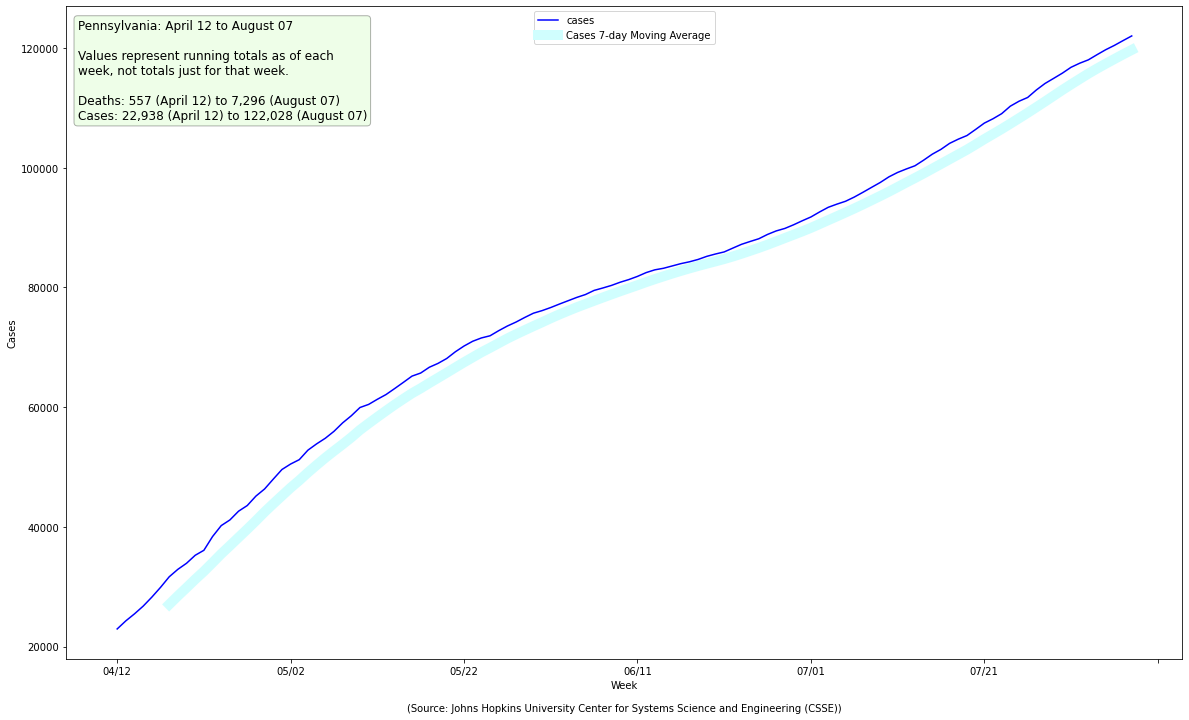

In [18]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50add67f0>)

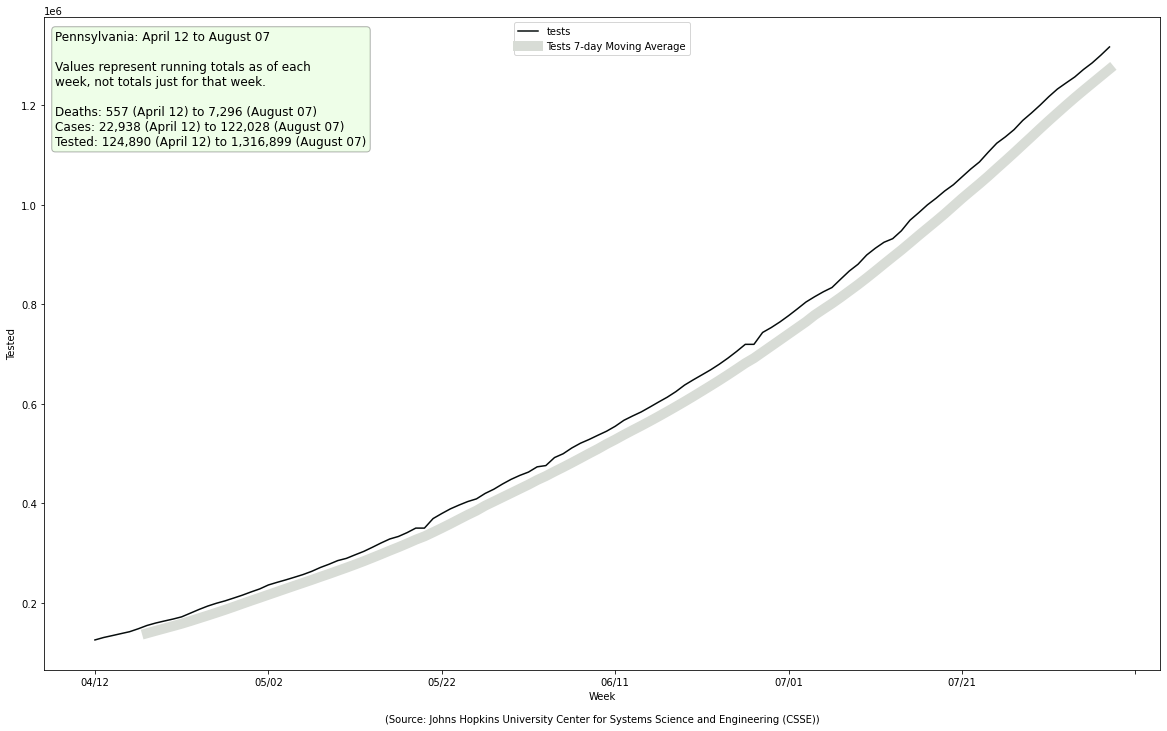

In [19]:
plot_state(df, SOURCE, 'Pennsylvania', image_file='jhu-pa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50ad41a00>)

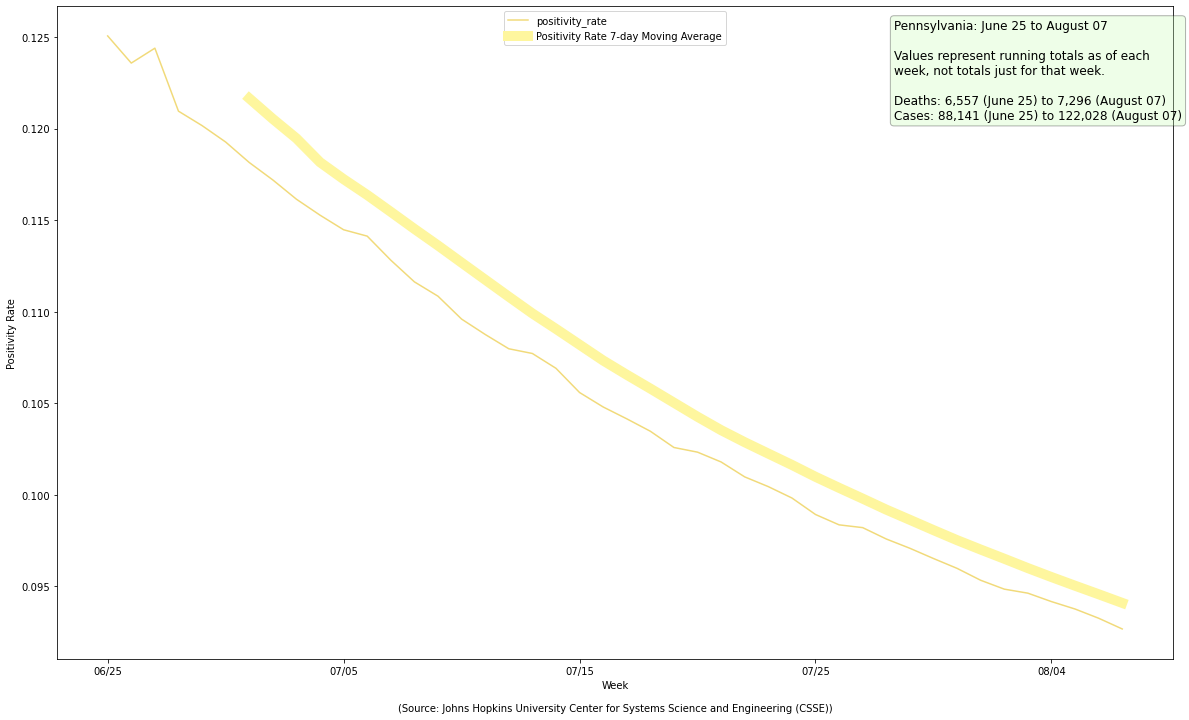

In [20]:
# Note caveats on positivity rate in the U.S. section, above.
plot_state(df_positivity_dates, SOURCE, 'Pennsylvania', metrics={MetricType.POSITIVITY},
           image_file='jhu-pa-positivity.png', moving_average=True, textbox_loc=(0.75, 0.98))

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50acf1b50>)

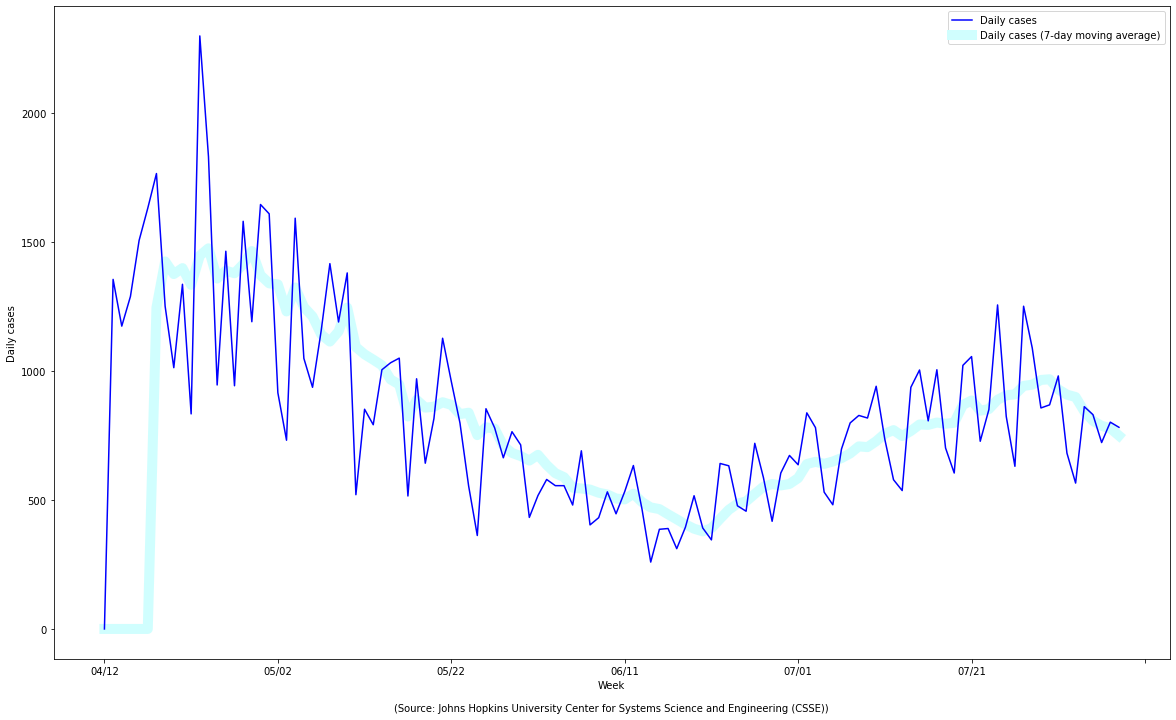

In [21]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.CASES,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-cases-daily.png")

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50acf1b20>)

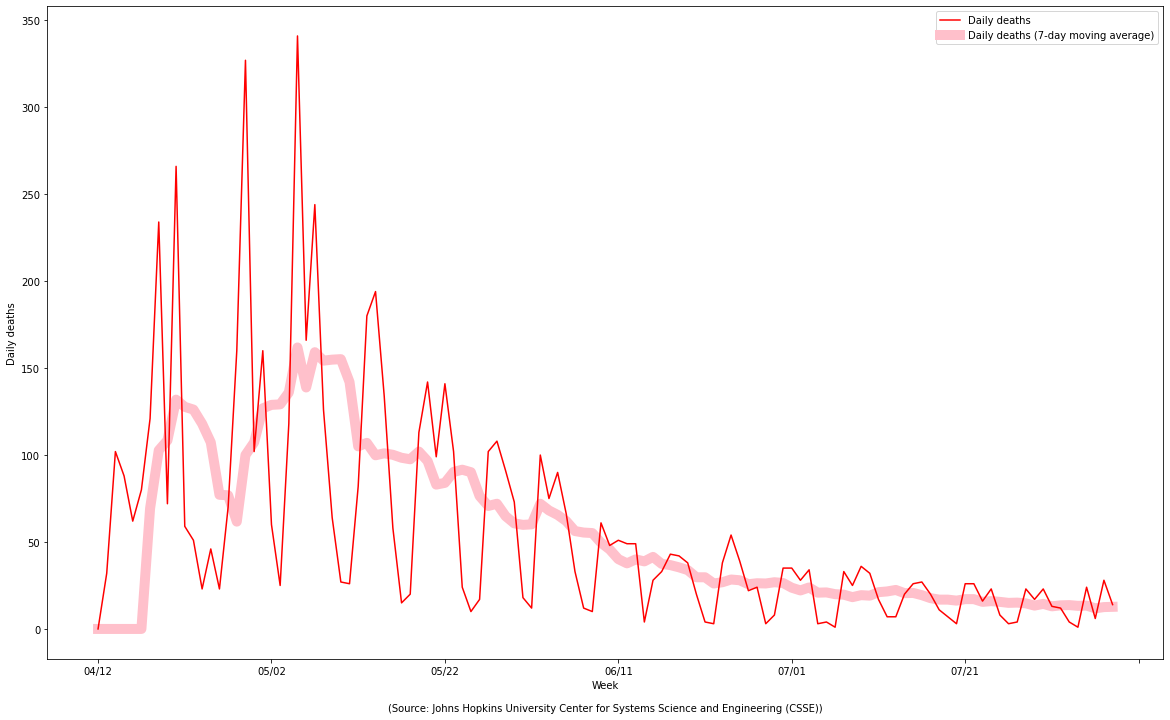

In [22]:
plot_daily_stats(df, 
                 source=SOURCE,
                 metric=MetricType.DEATHS,
                 region='Pennsylvania',
                 moving_average=True,
                 image_file="jhu-pa-deaths-daily.png")

#### New York

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50802b580>)

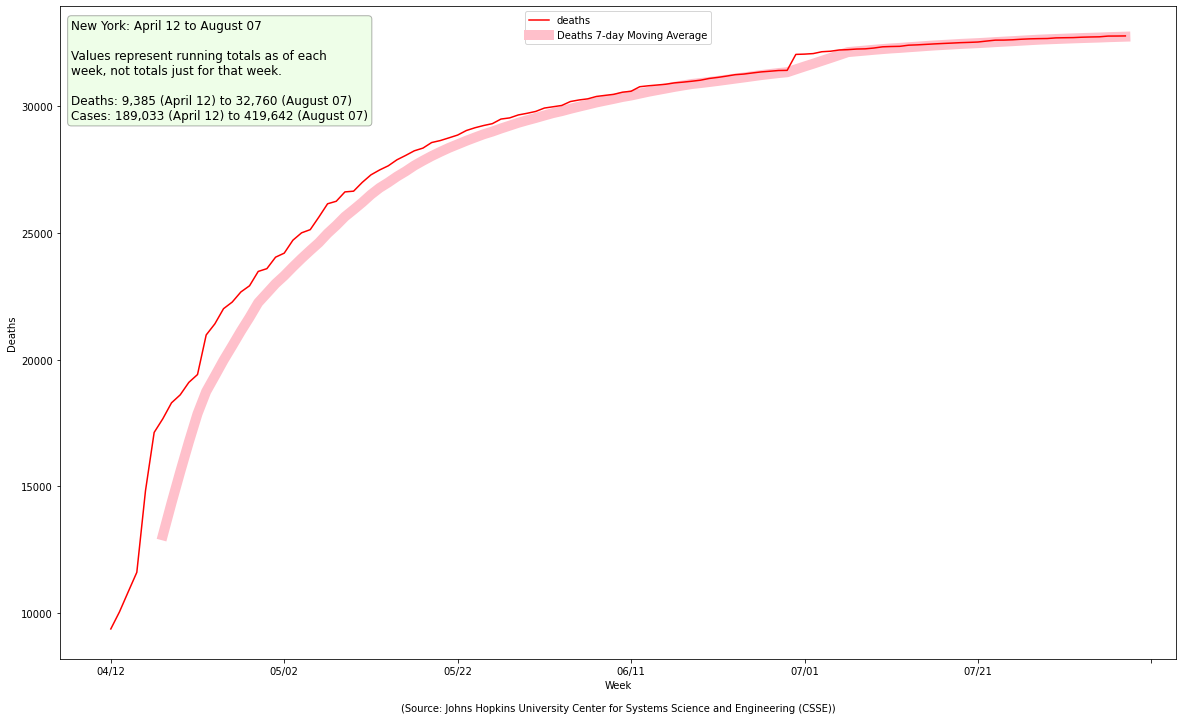

In [23]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501ff64c0>)

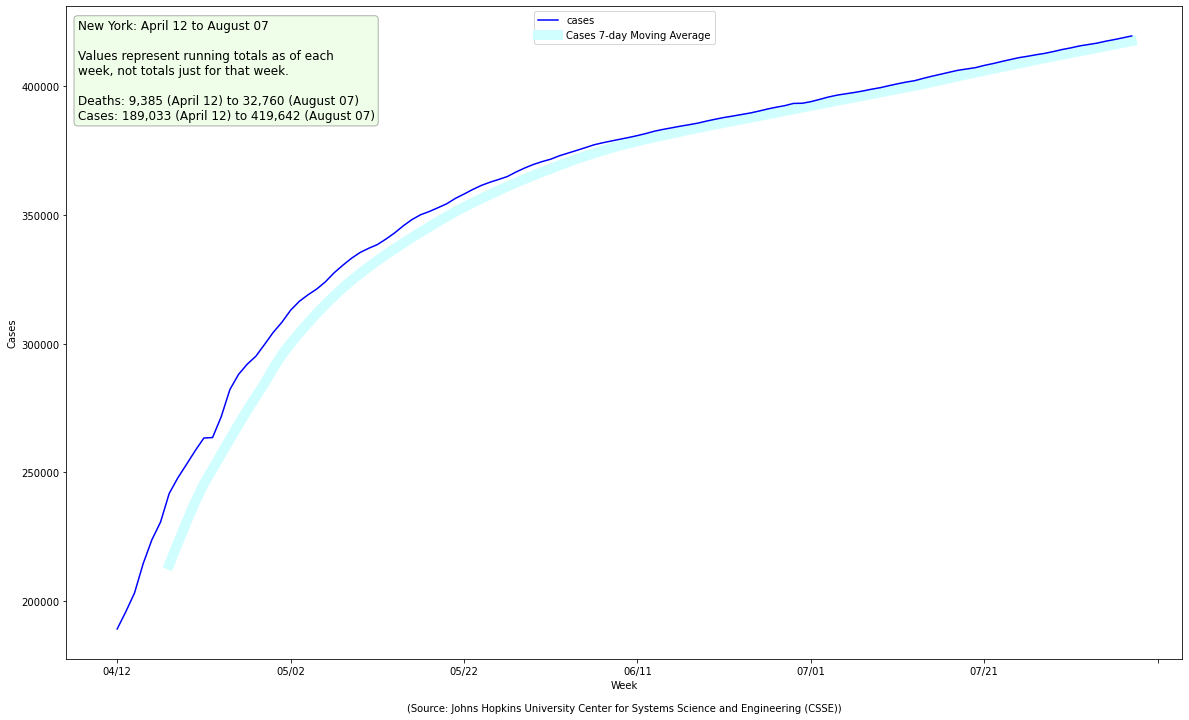

In [24]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501f65580>)

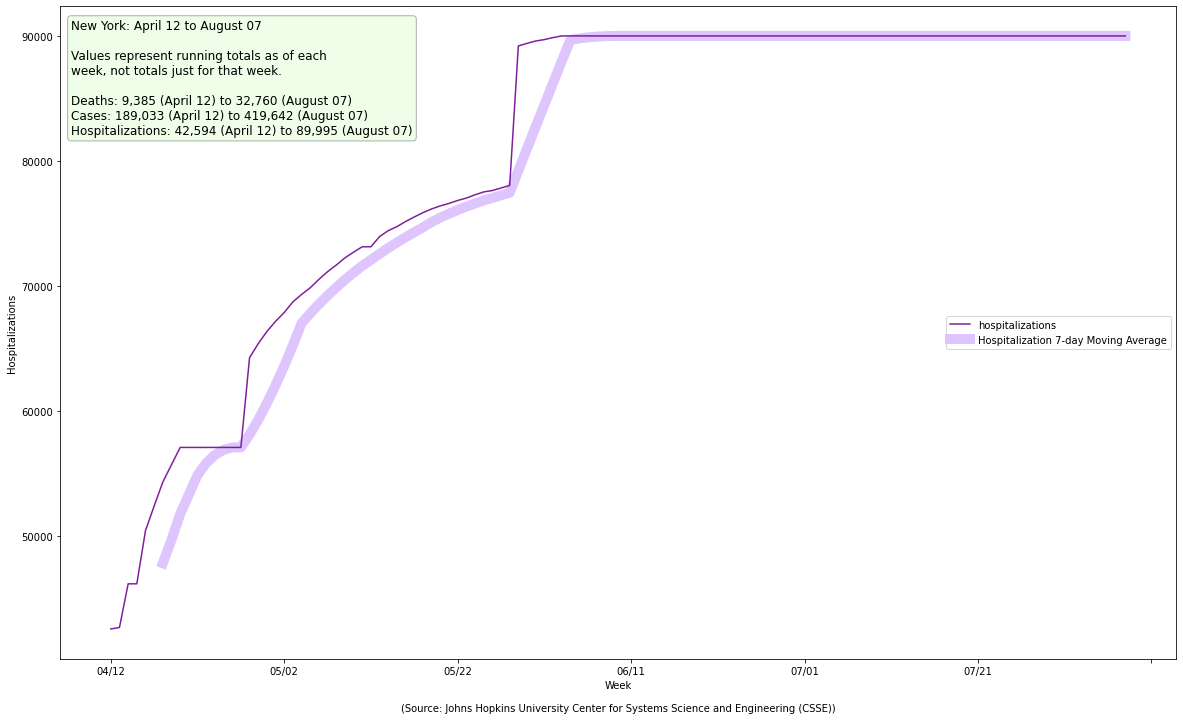

In [25]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, 
           moving_average=True, legend_loc='center right')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501ebeaf0>)

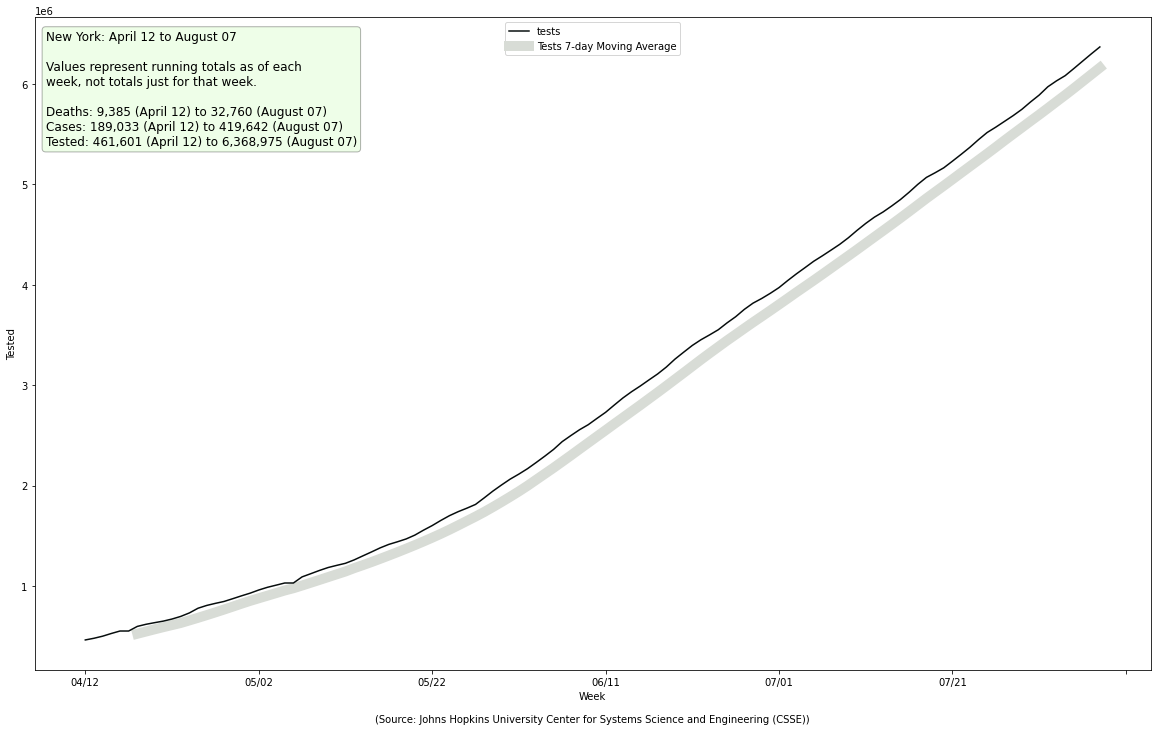

In [26]:
plot_state(df, SOURCE, 'New York', image_file='jhu-ny-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50b0991f0>)

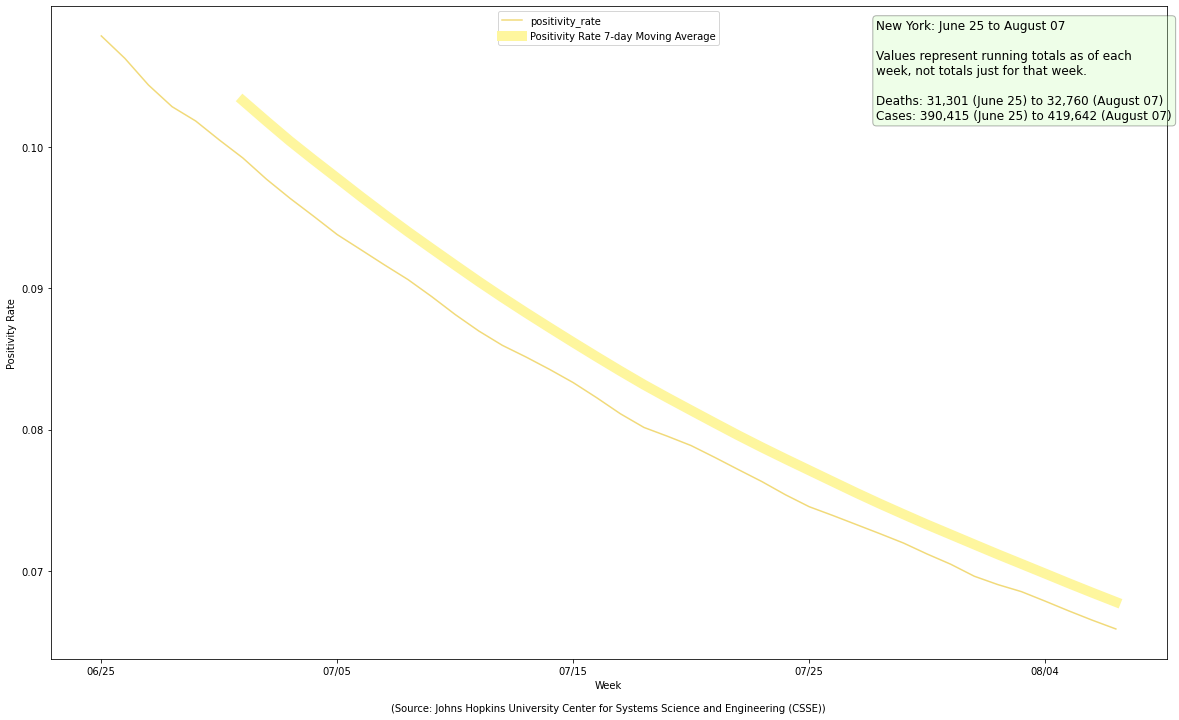

In [27]:
plot_state(df_positivity_dates, SOURCE, 'New York', image_file='jhu-ny-pos.png', 
           metrics={MetricType.POSITIVITY}, textbox_loc=(0.74, 0.98), moving_average=True)

#### California

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501f5d1f0>)

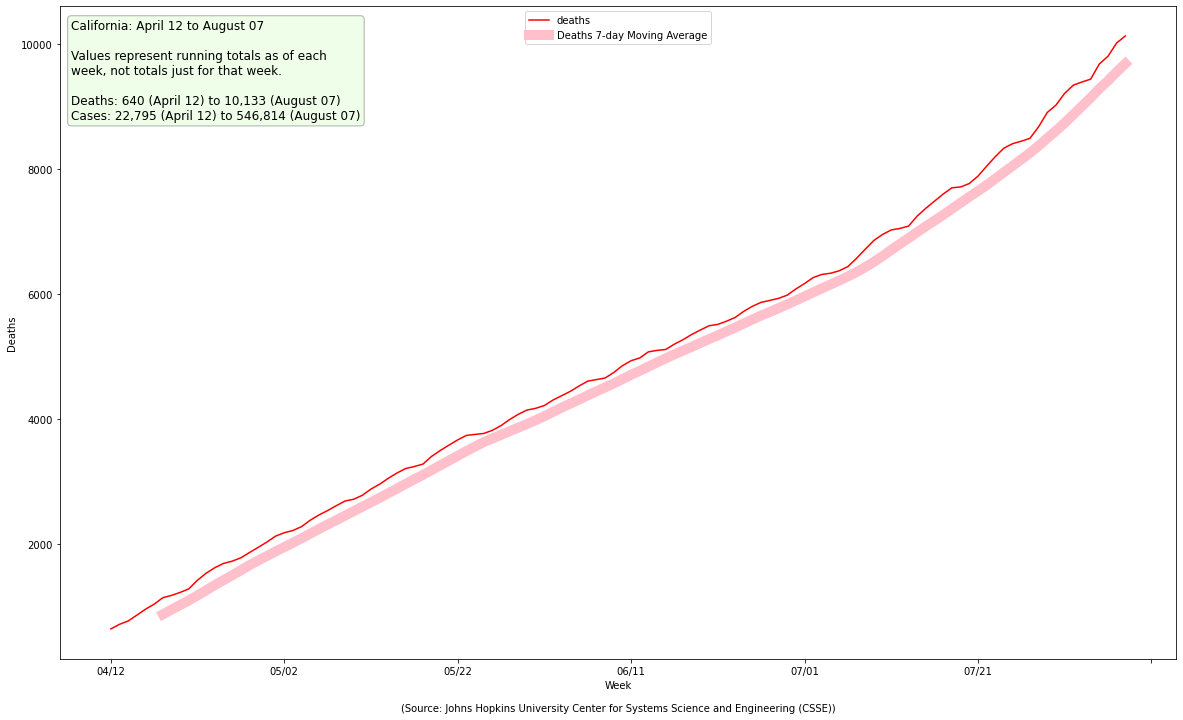

In [28]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501dbe520>)

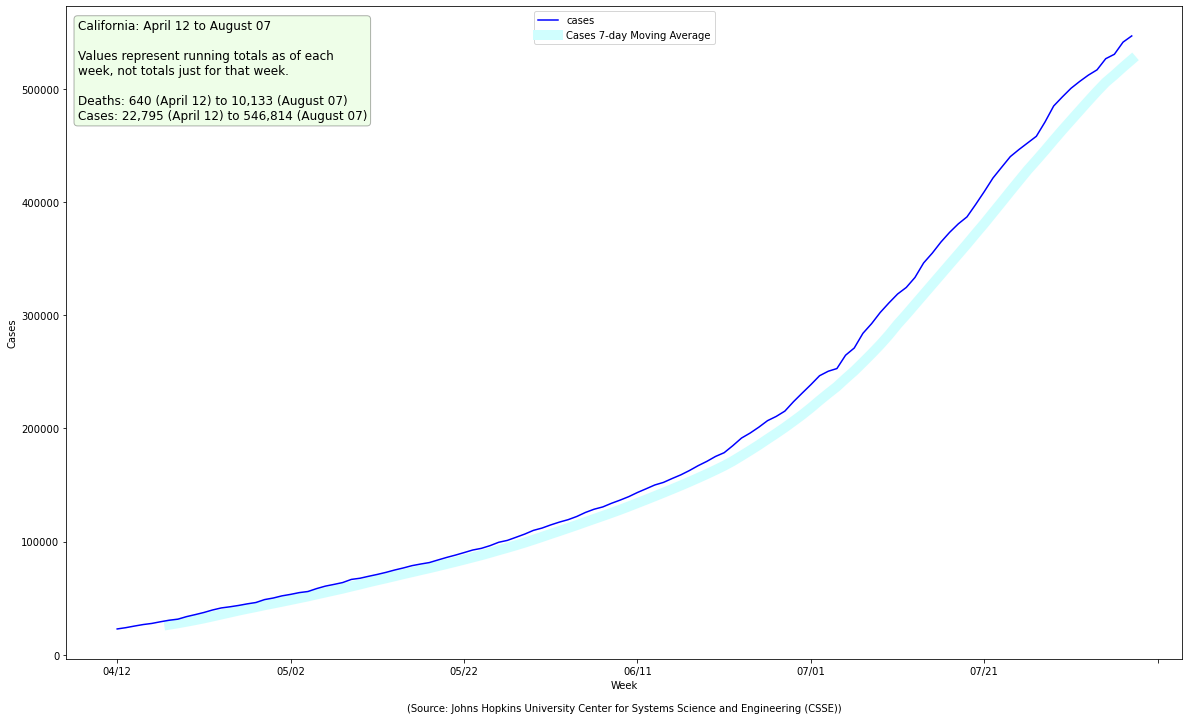

In [29]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501daf160>)

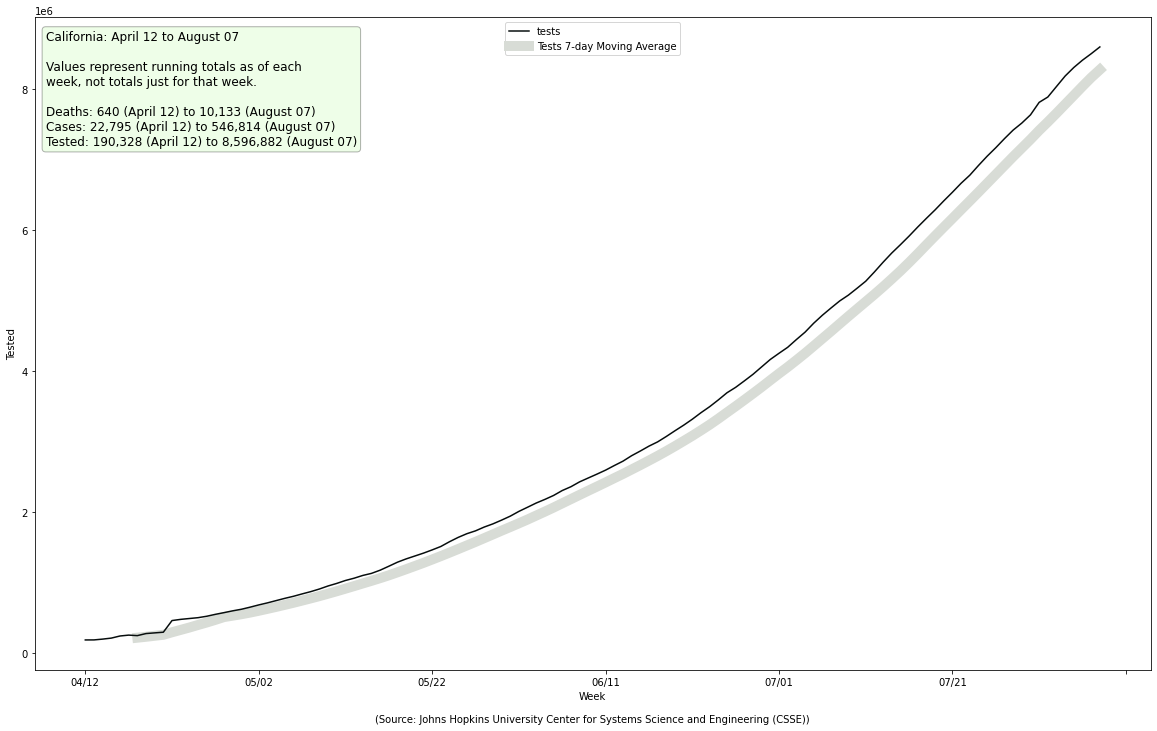

In [30]:
plot_state(df, SOURCE, 'California', image_file='jhu-ca-tests.png', 
           metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501d18820>)

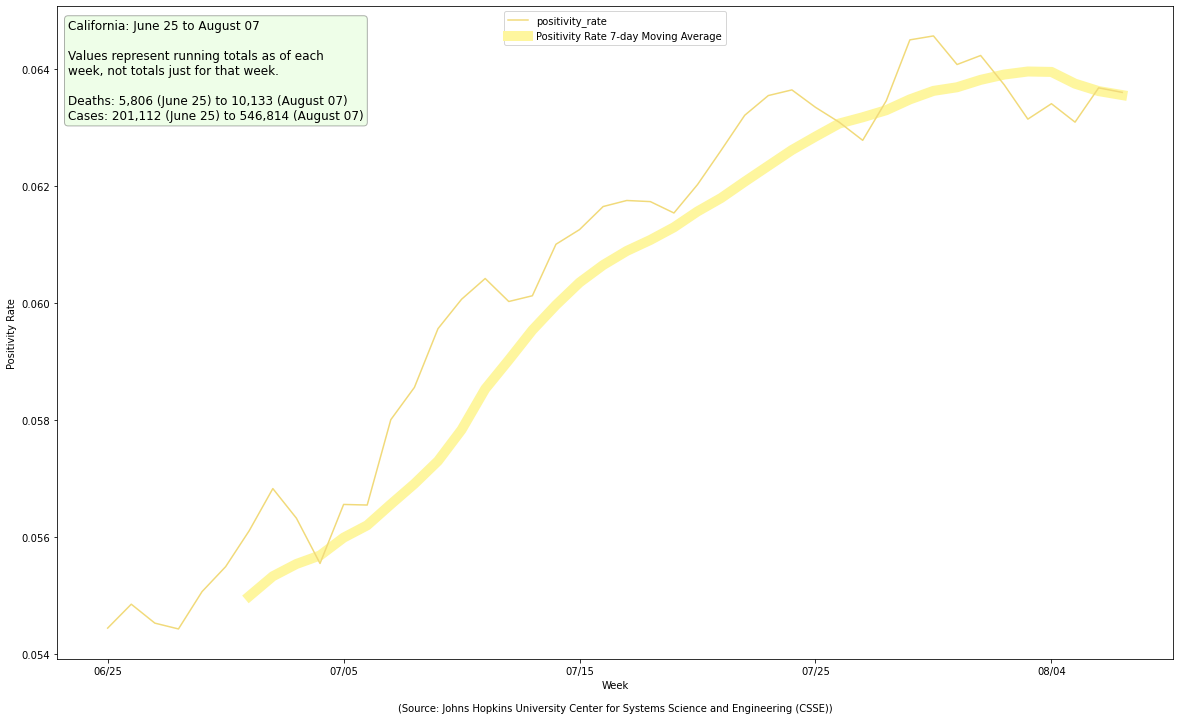

In [31]:
plot_state(df_positivity_dates, SOURCE, 'California', image_file='jhu-ca-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Washington

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501cdbf40>)

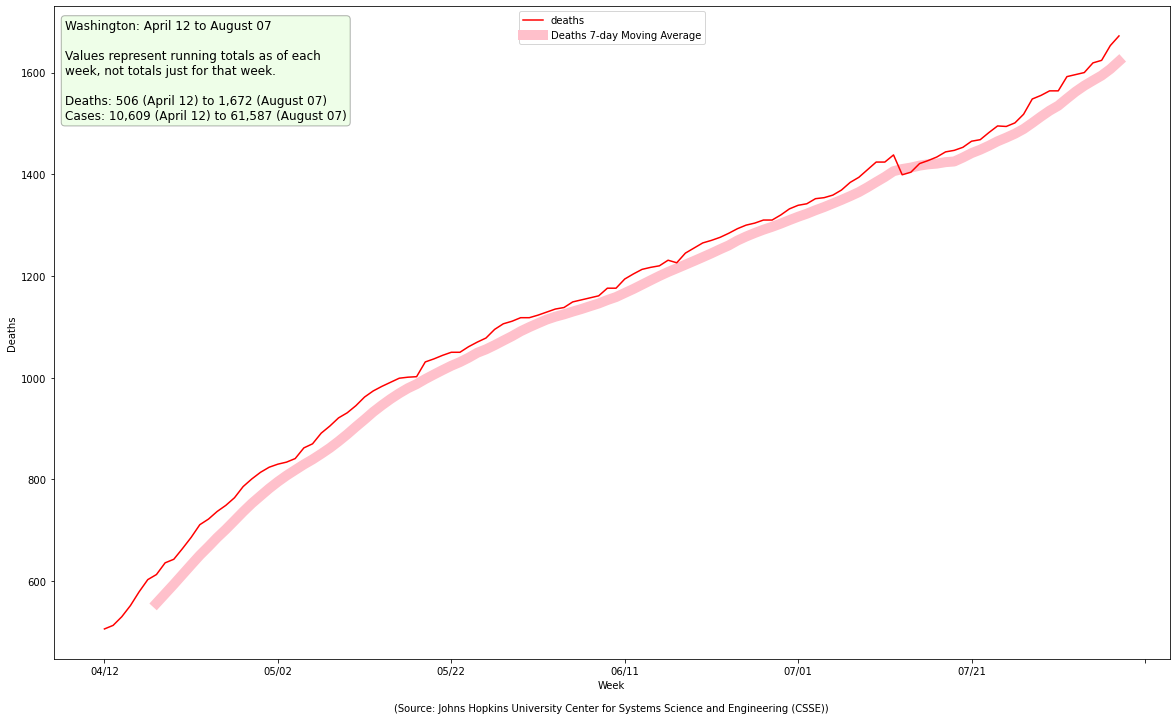

In [32]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501c5d730>)

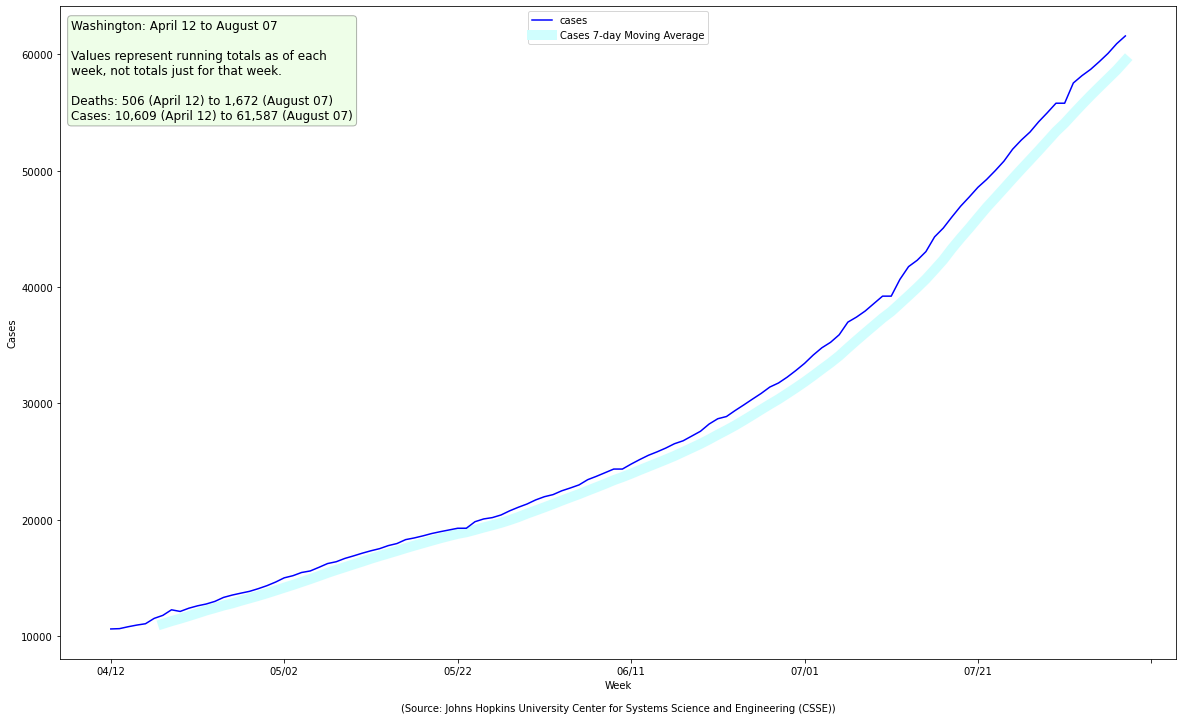

In [33]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501bc66d0>)

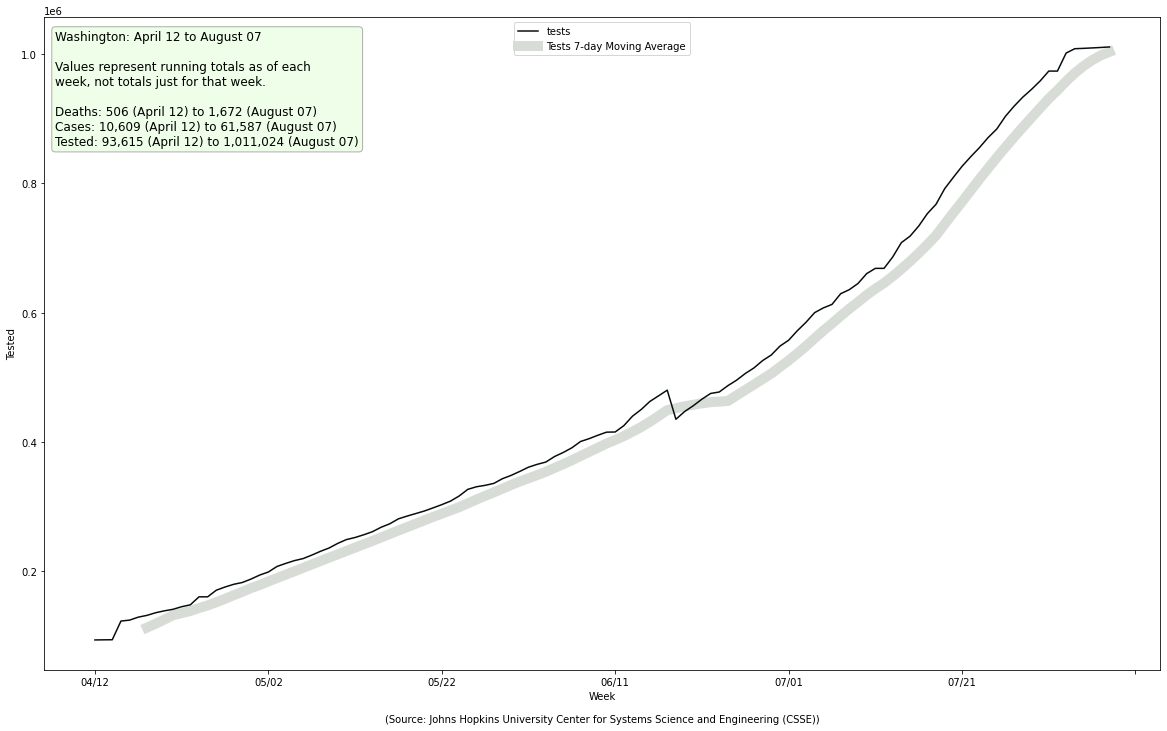

In [34]:
plot_state(df, SOURCE, 'Washington', image_file='jhu-wa-tests.png', metrics={MetricType.TESTED}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501bac520>)

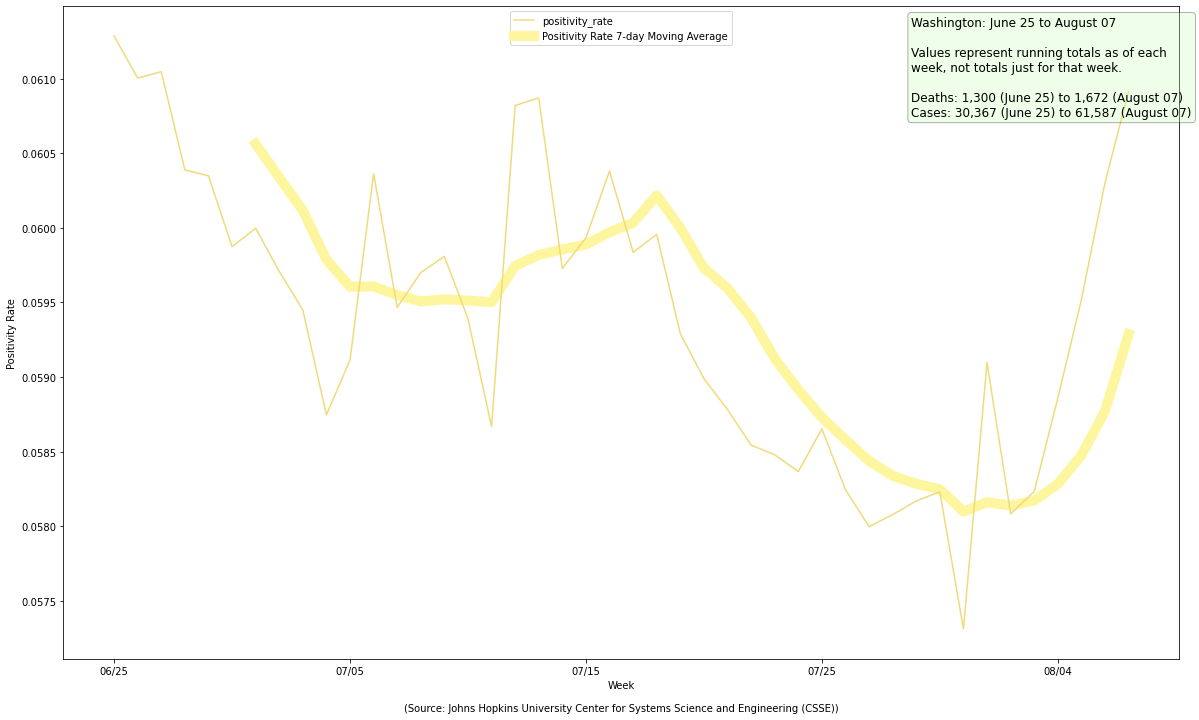

In [35]:
plot_state(df_positivity_dates, SOURCE, 'Washington', image_file='jhu-wa-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True, textbox_loc=(0.76, 0.985))

#### Delaware

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501b6e580>)

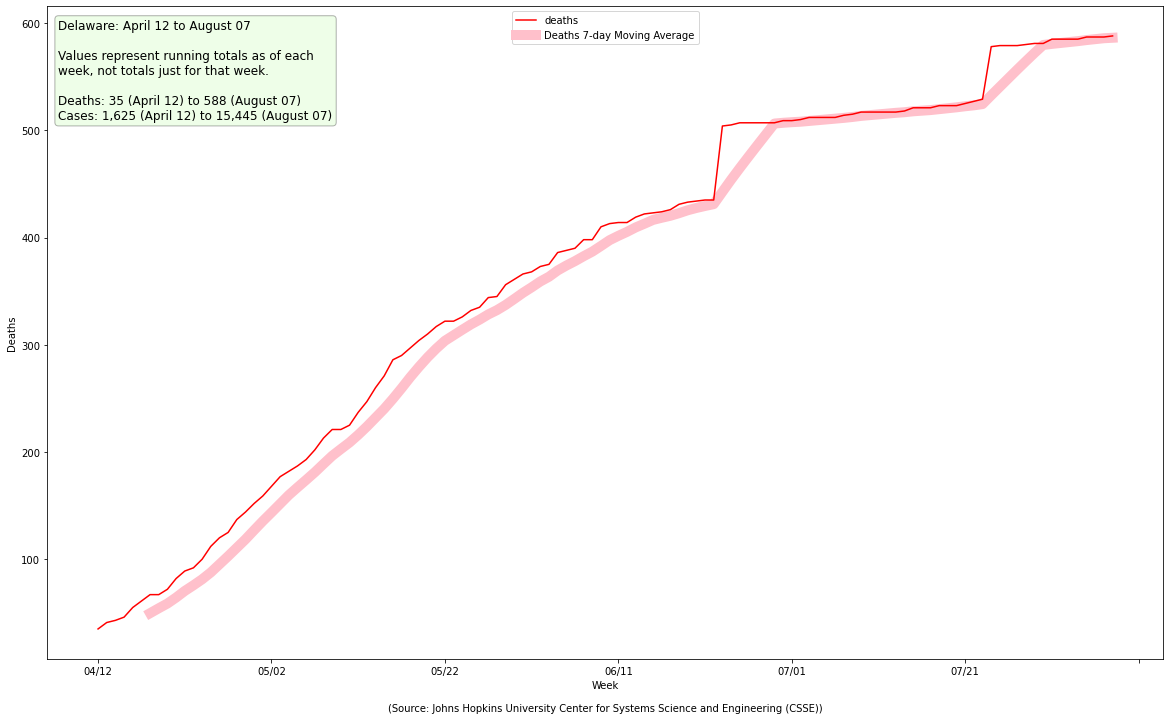

In [36]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501b33cd0>)

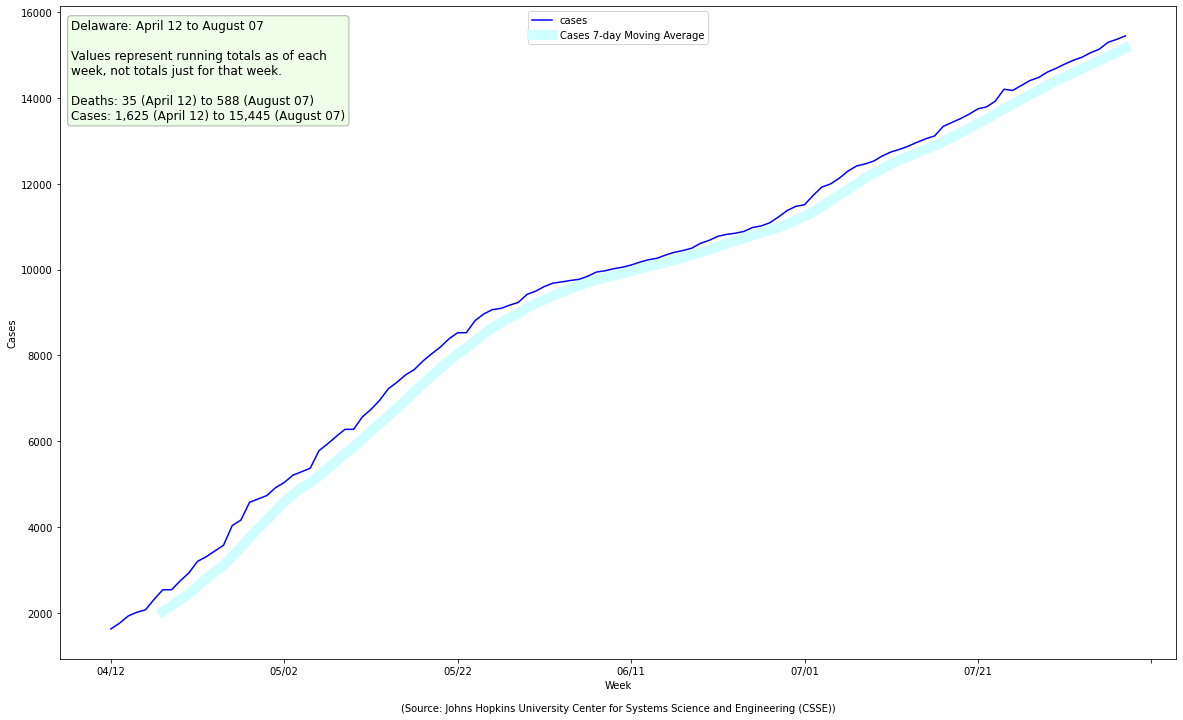

In [37]:
plot_state(df, SOURCE, 'Delaware', image_file='jhu-de-cases.png', metrics={MetricType.CASES}, moving_average=True)

#### Texas

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501aa8f10>)

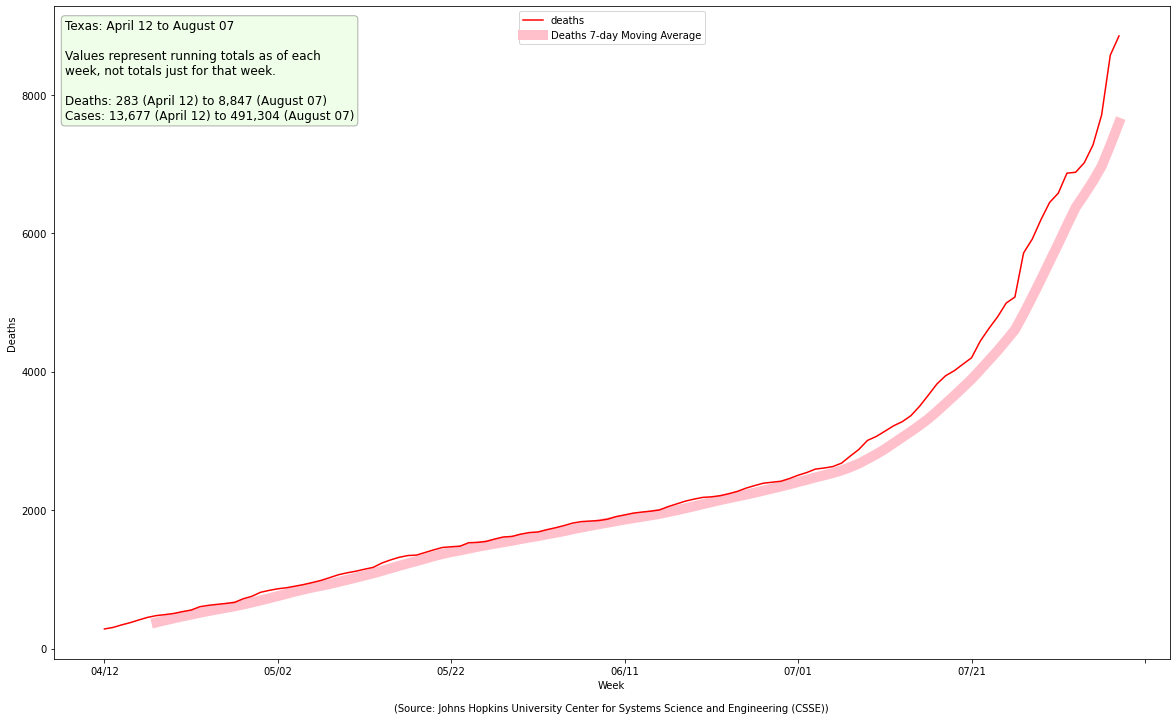

In [38]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501d14130>)

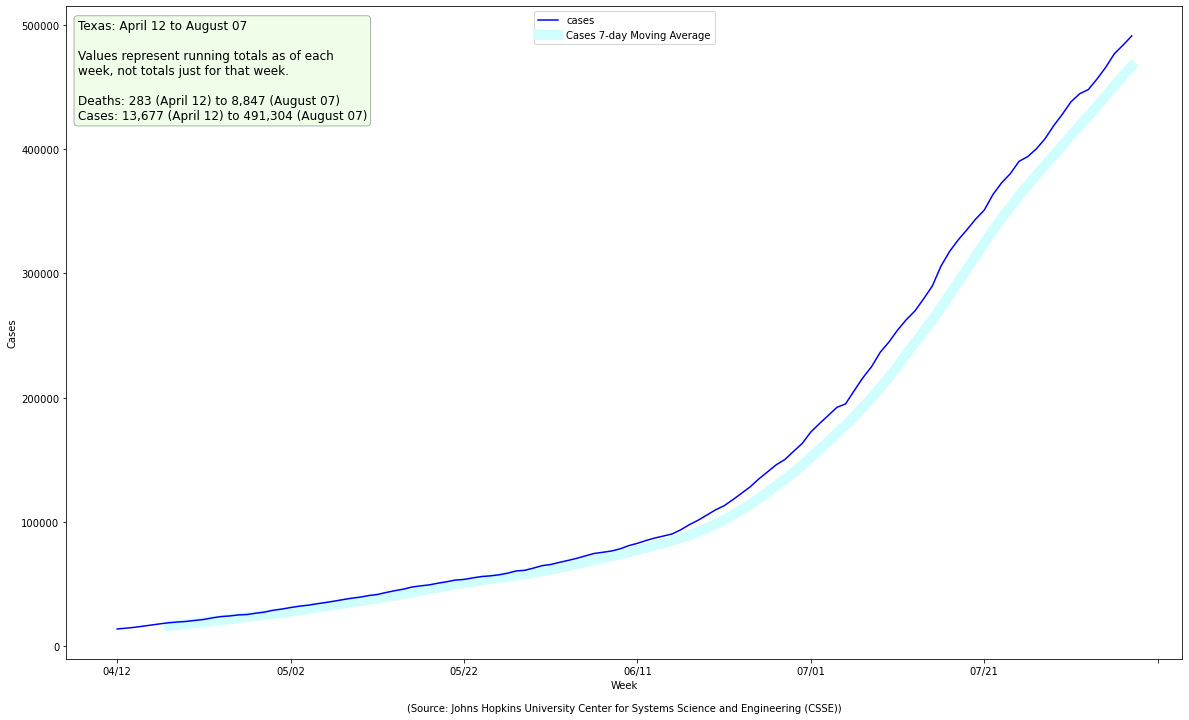

In [39]:
plot_state(df, SOURCE, 'Texas', image_file='jhu-tx-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501a6ed60>)

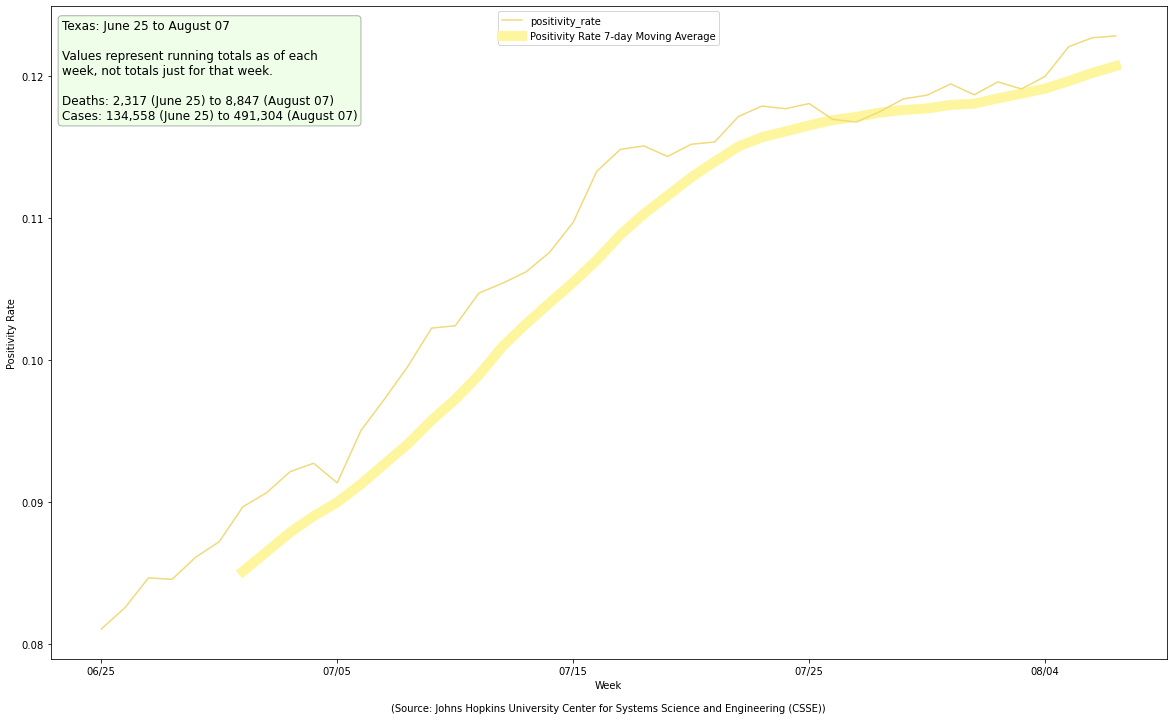

In [40]:
plot_state(df_positivity_dates, SOURCE, 'Texas', image_file='jhu-tx-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5019acf10>)

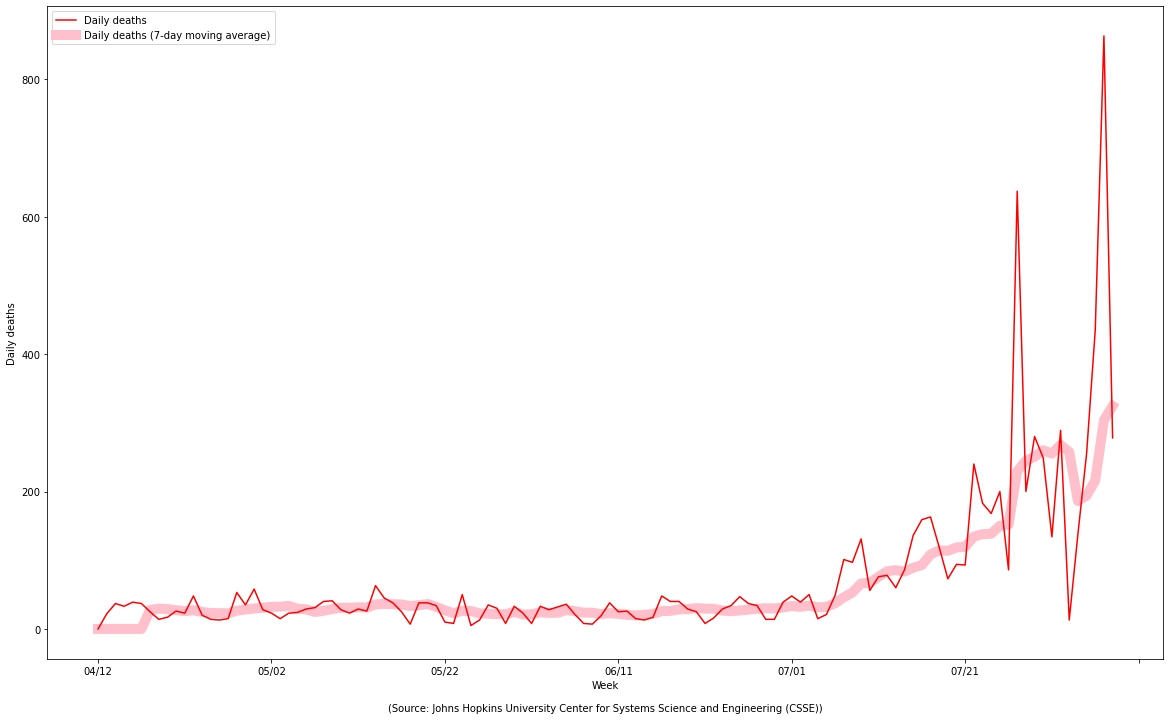

In [41]:
plot_daily_stats(df, SOURCE, region='Texas', metric=MetricType.DEATHS, moving_average=True, image_file="jhu-tx-daily-deaths.png")

#### Georgia

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501934d90>)

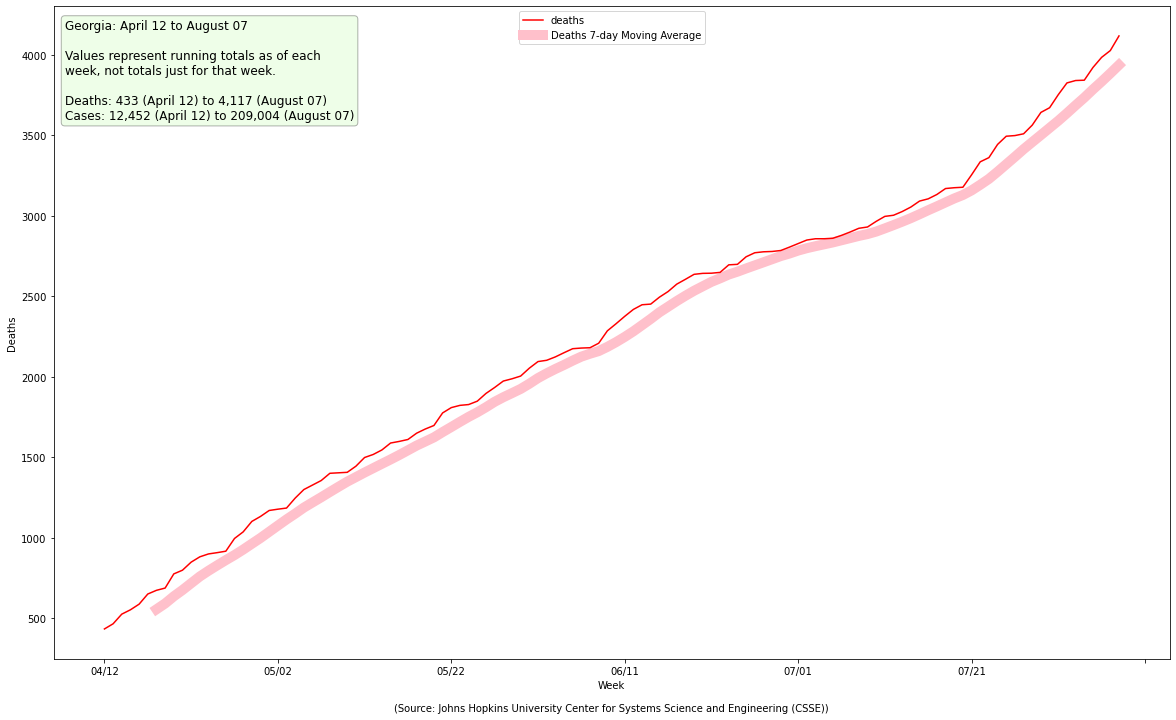

In [42]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50188efa0>)

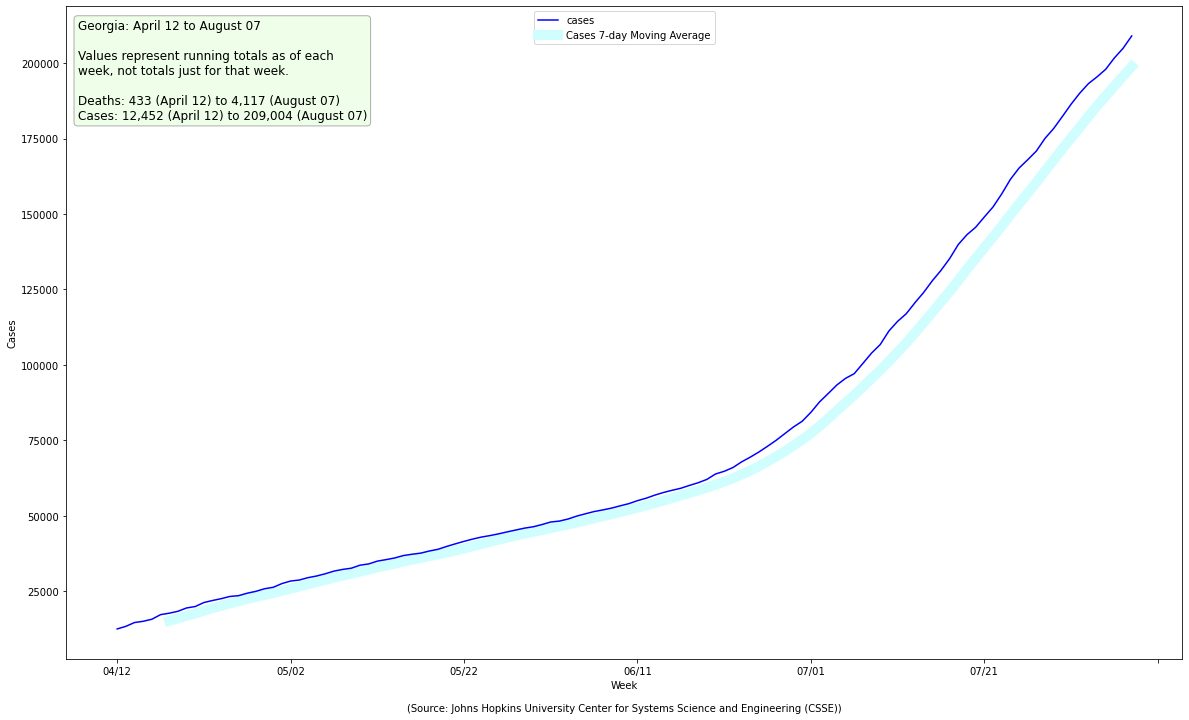

In [43]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5018138e0>)

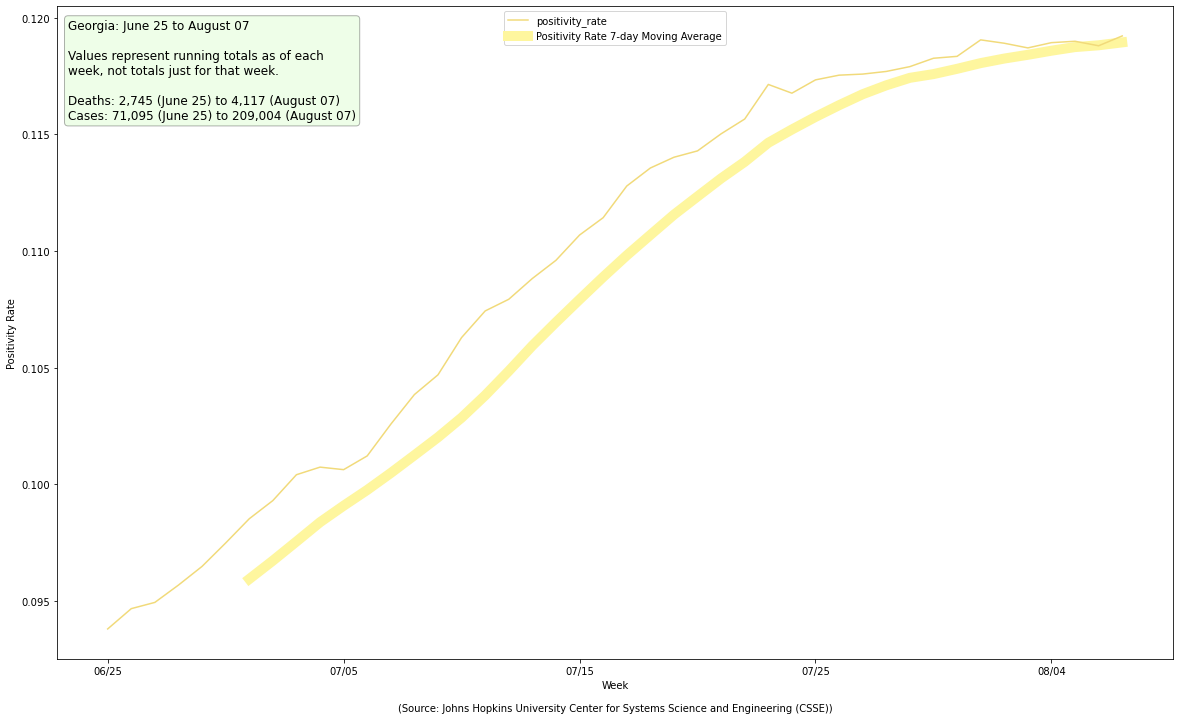

In [44]:
plot_state(df_positivity_dates, SOURCE, 'Georgia', image_file='jhu-ga-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5017daca0>)

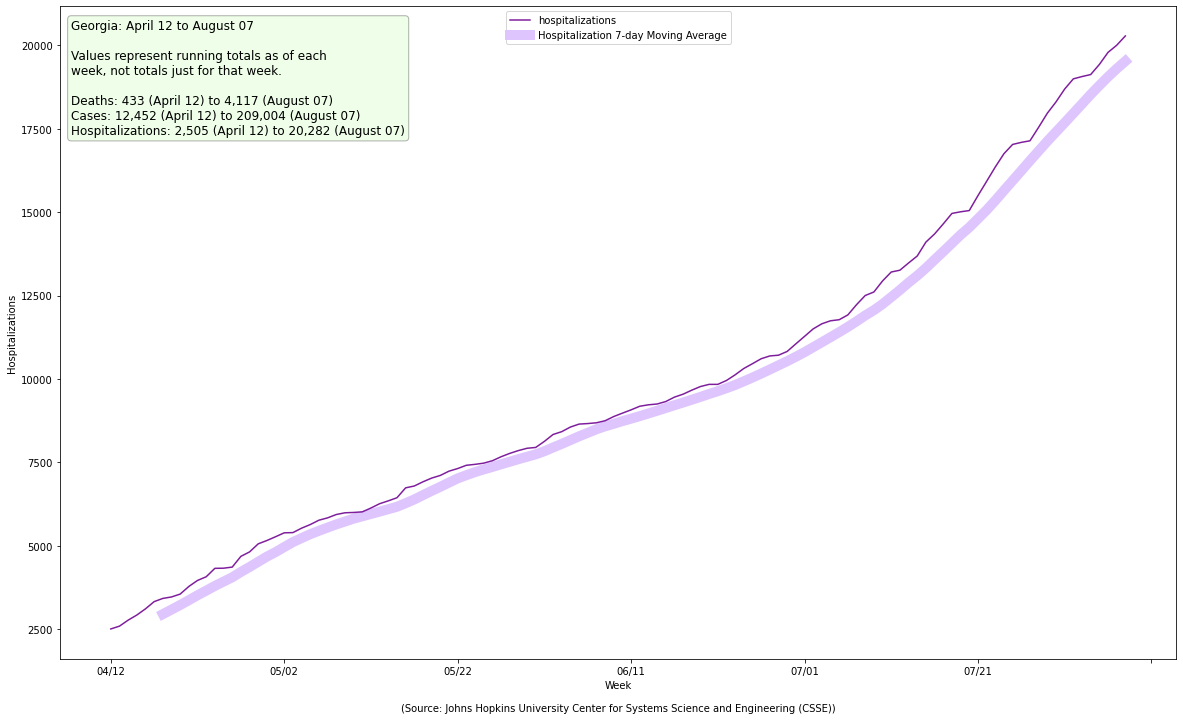

In [45]:
plot_state(df, SOURCE, 'Georgia', image_file='jhu-ga-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Mississippi

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5017bf430>)

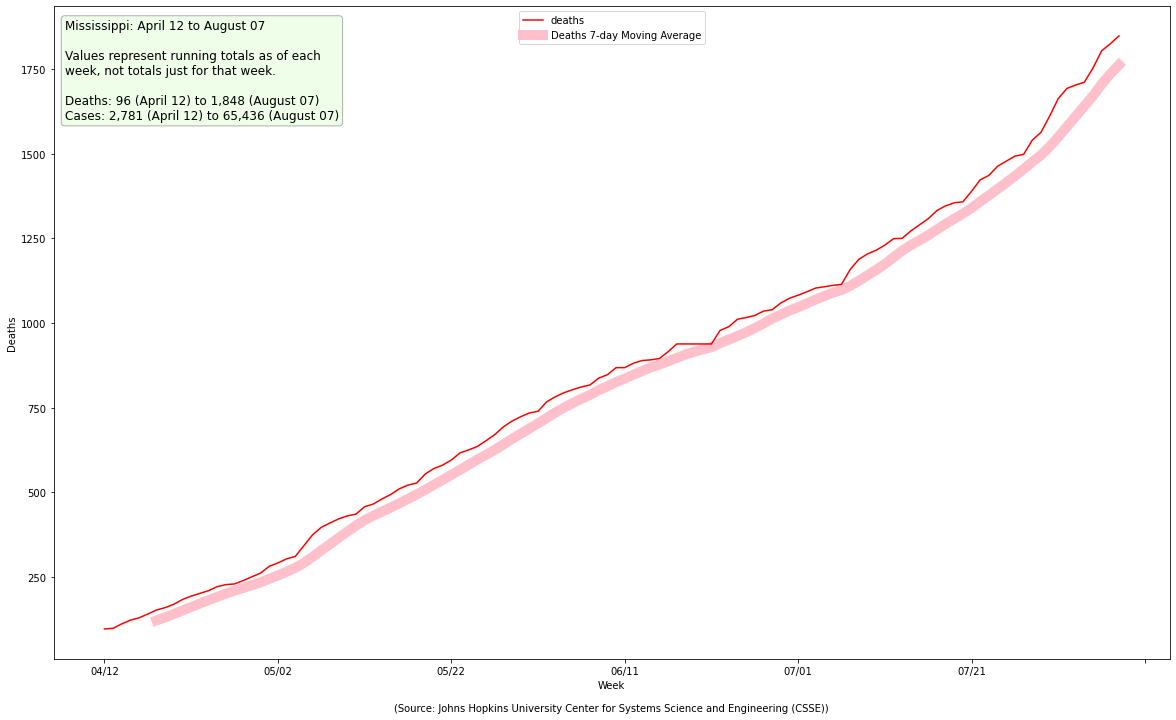

In [46]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5016cd6a0>)

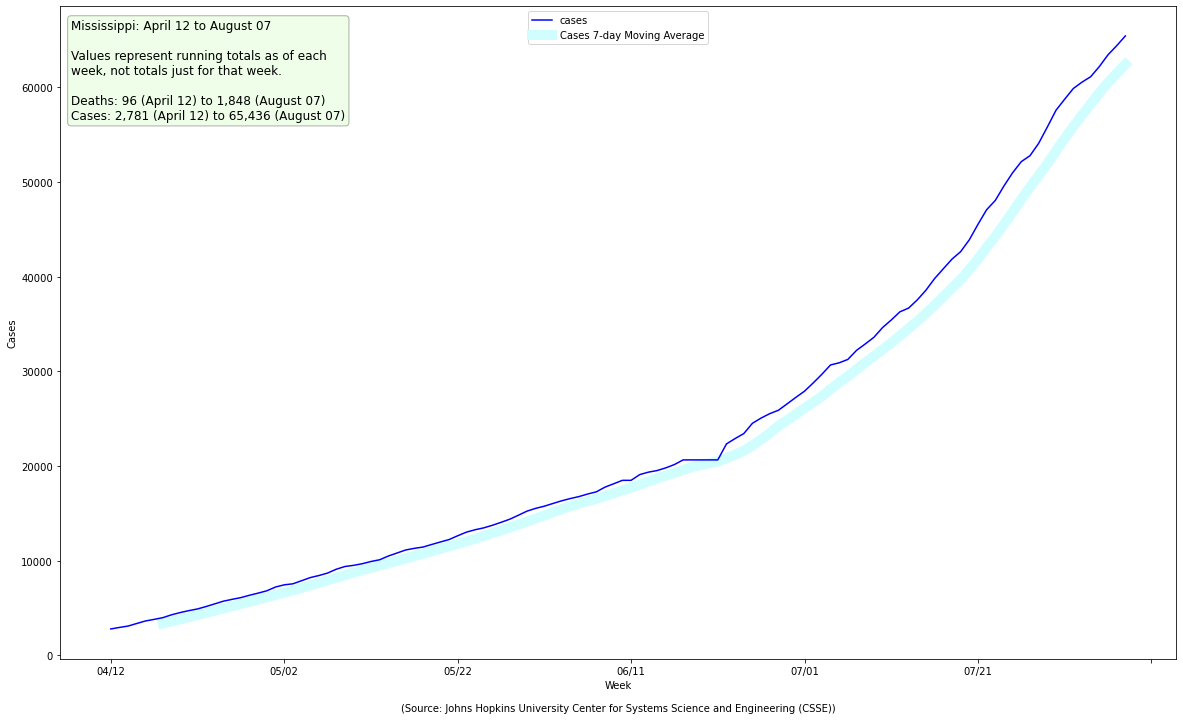

In [47]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5016b7cd0>)

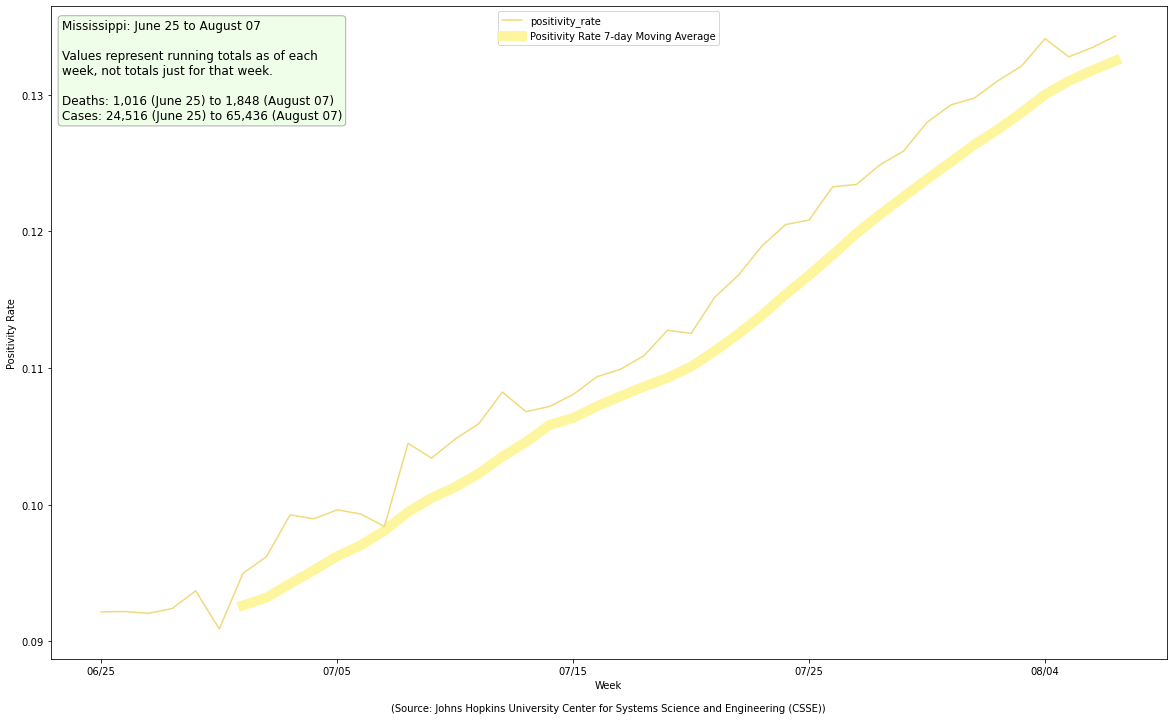

In [48]:
plot_state(df_positivity_dates, SOURCE, 'Mississippi', image_file='jhu-ms-pos.png', metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501678be0>)

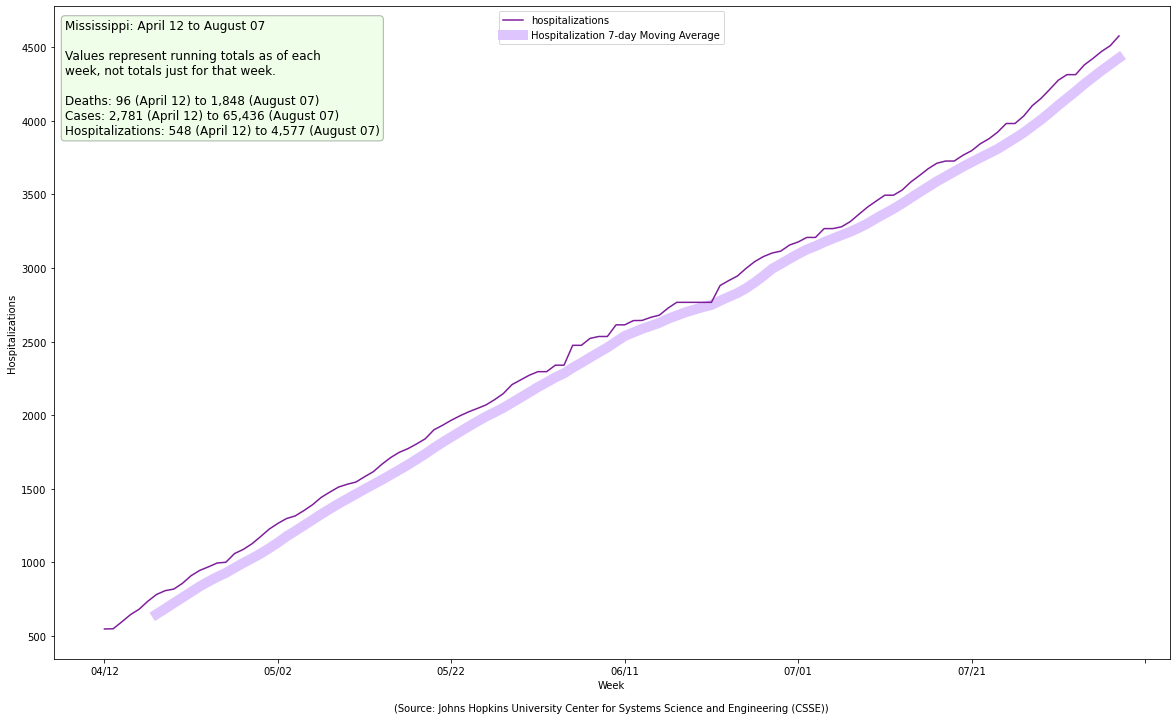

In [49]:
plot_state(df, SOURCE, 'Mississippi', image_file='jhu-ms-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Arizona

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5015c06d0>)

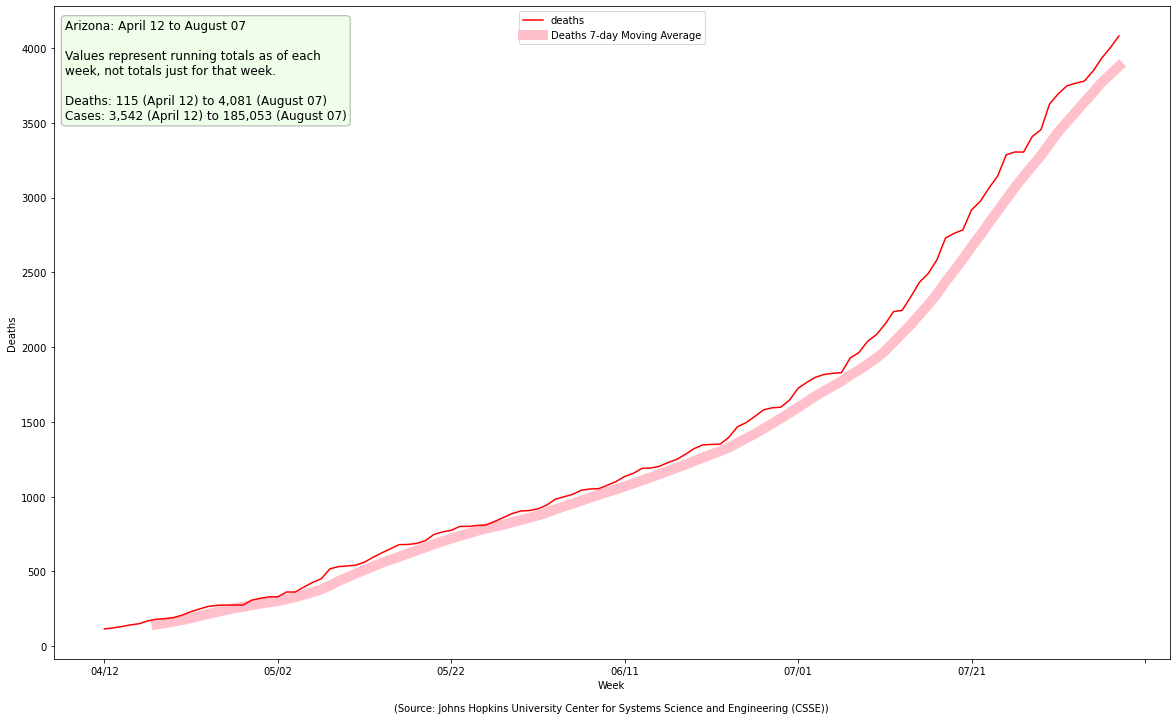

In [50]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5015f2be0>)

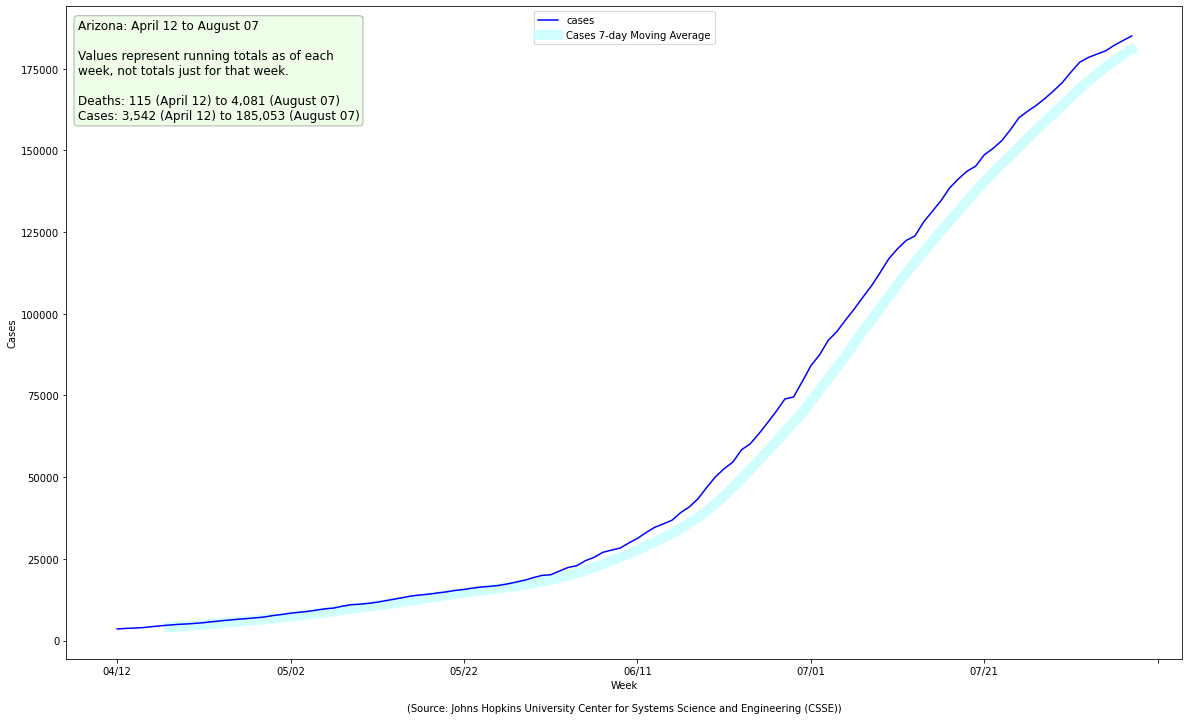

In [51]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5014d0a60>)

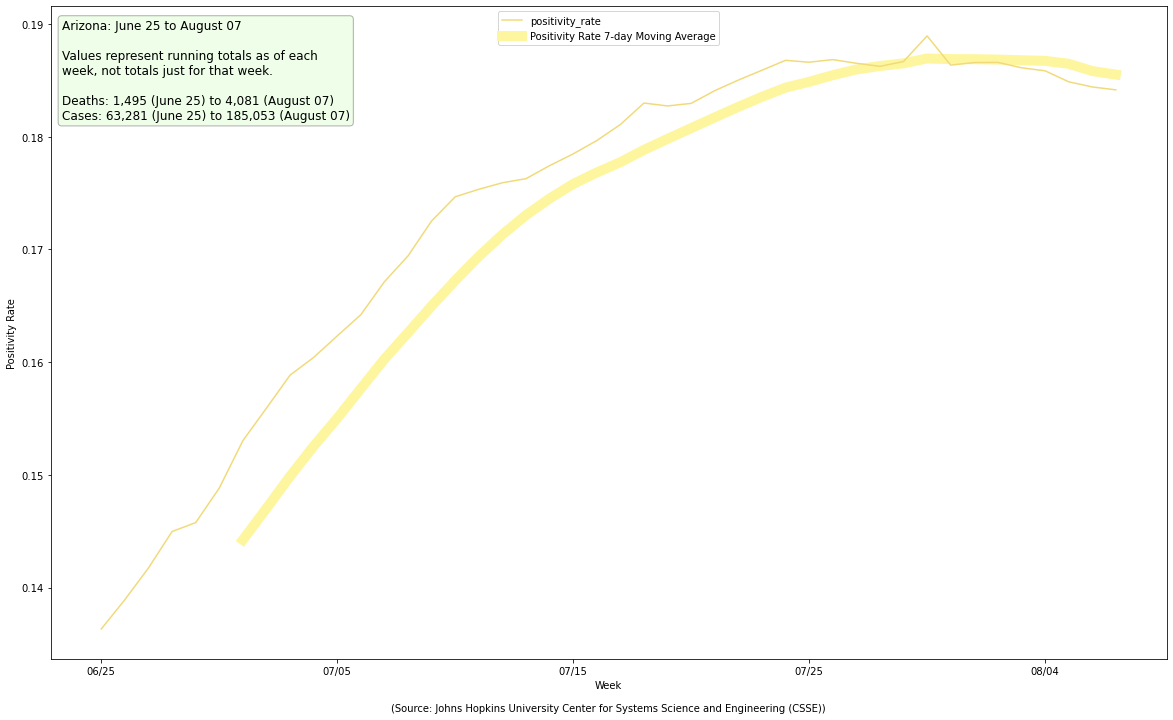

In [52]:
plot_state(df_positivity_dates, SOURCE, 'Arizona', image_file='jhu-az-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501492310>)

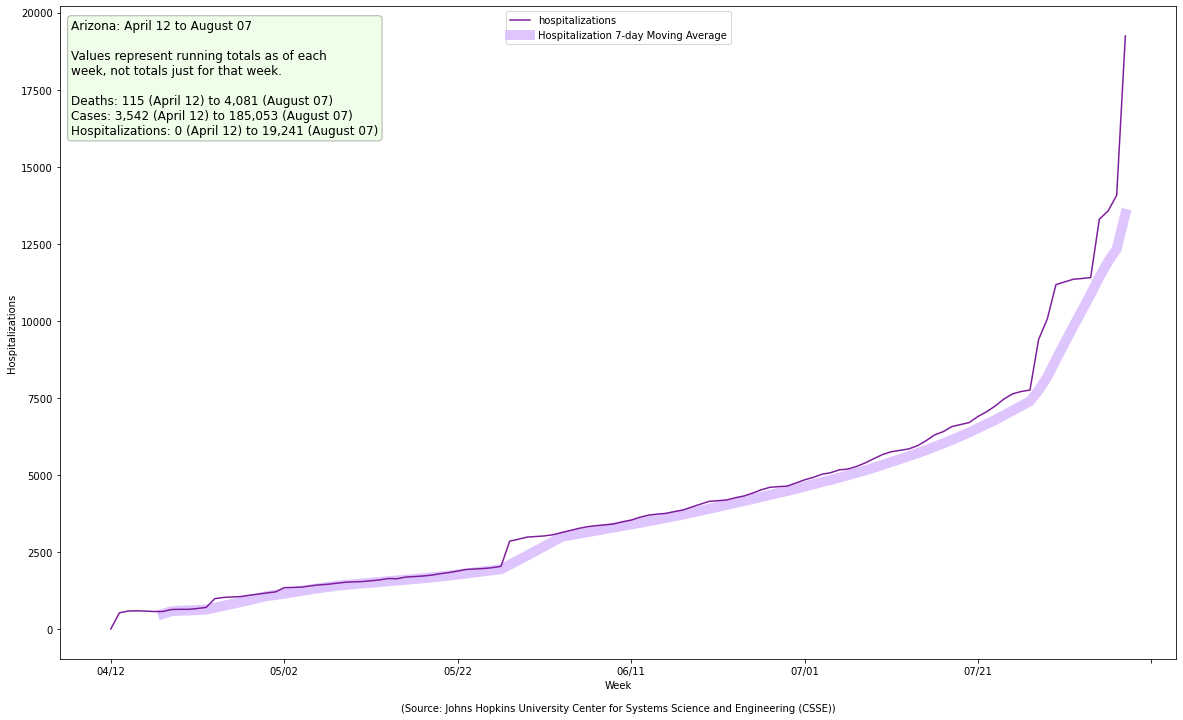

In [53]:
plot_state(df, SOURCE, 'Arizona', image_file='jhu-az-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

#### Florida

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501915700>)

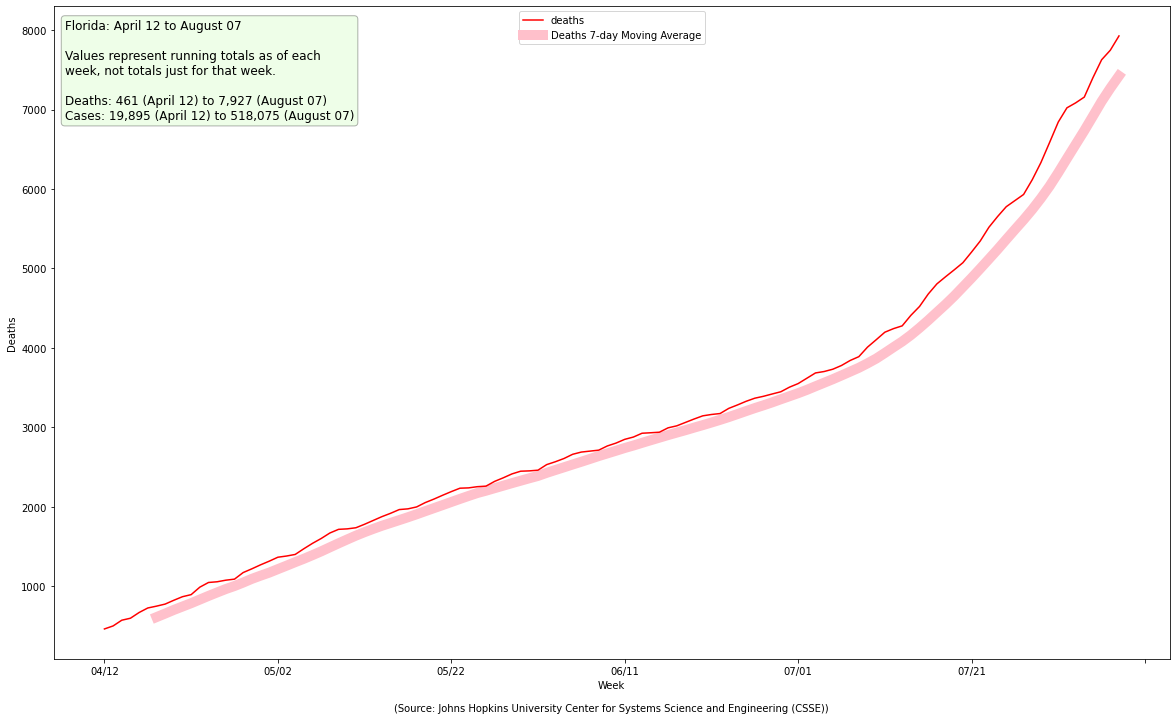

In [54]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501442c10>)

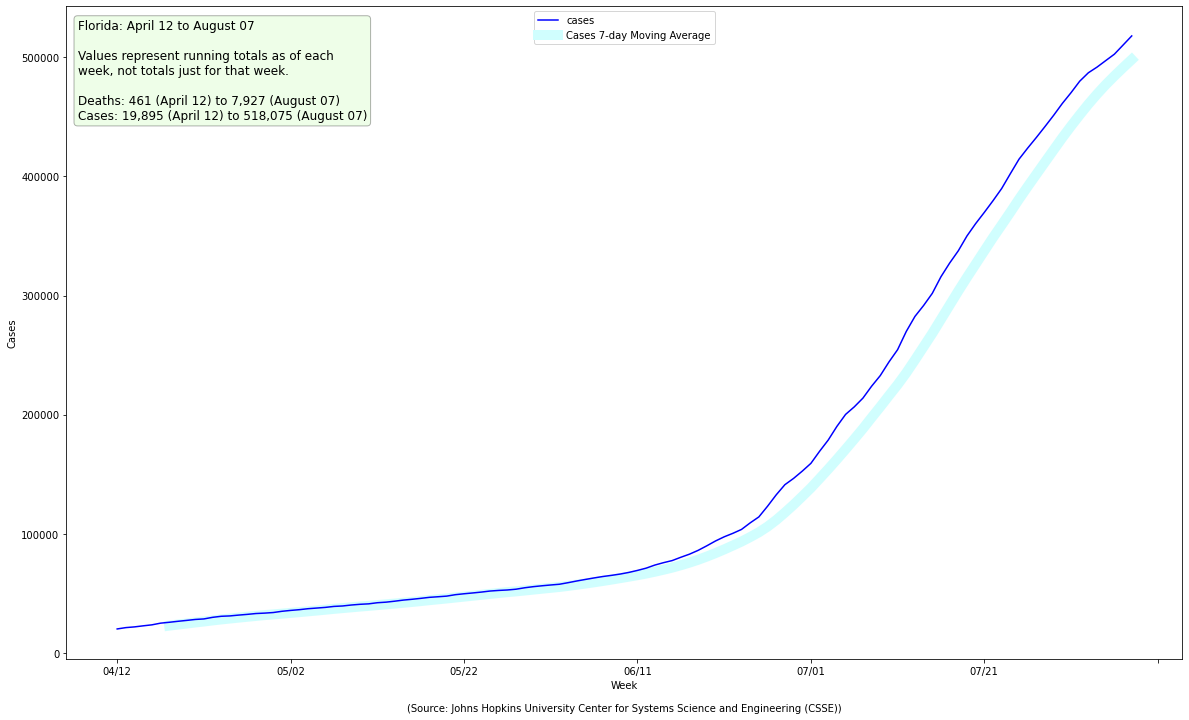

In [55]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50133e460>)

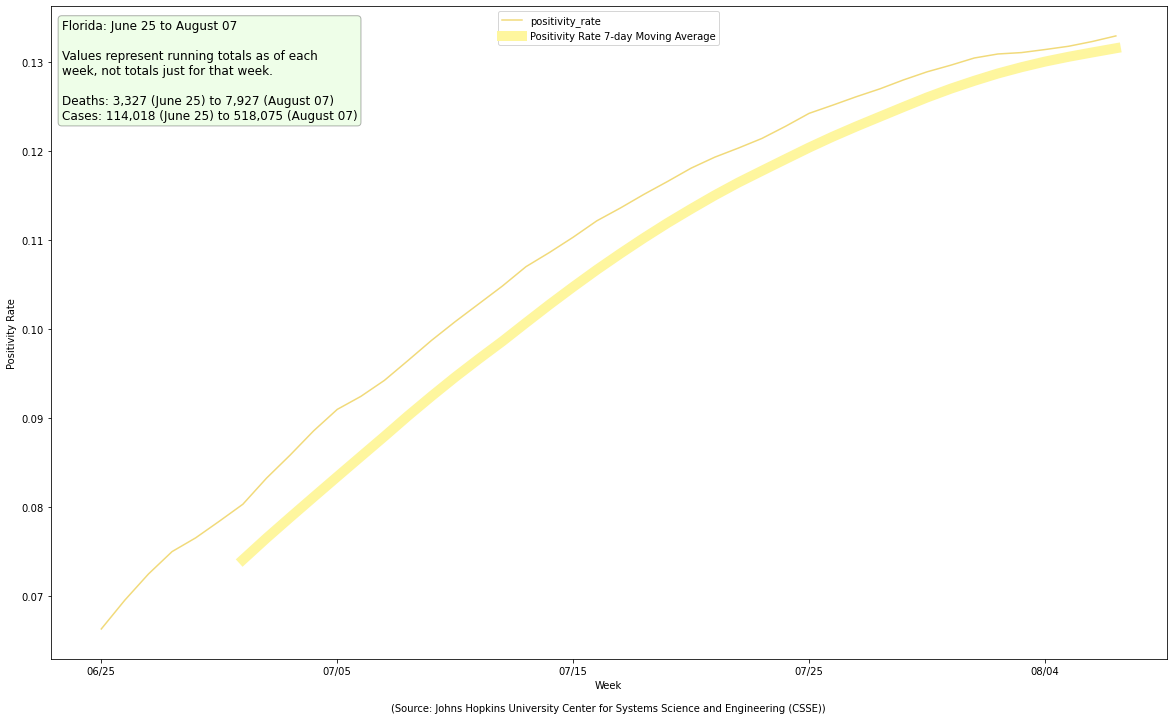

In [56]:
plot_state(df_positivity_dates, SOURCE, 'Florida', image_file='jhu-fl-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5012fd040>)

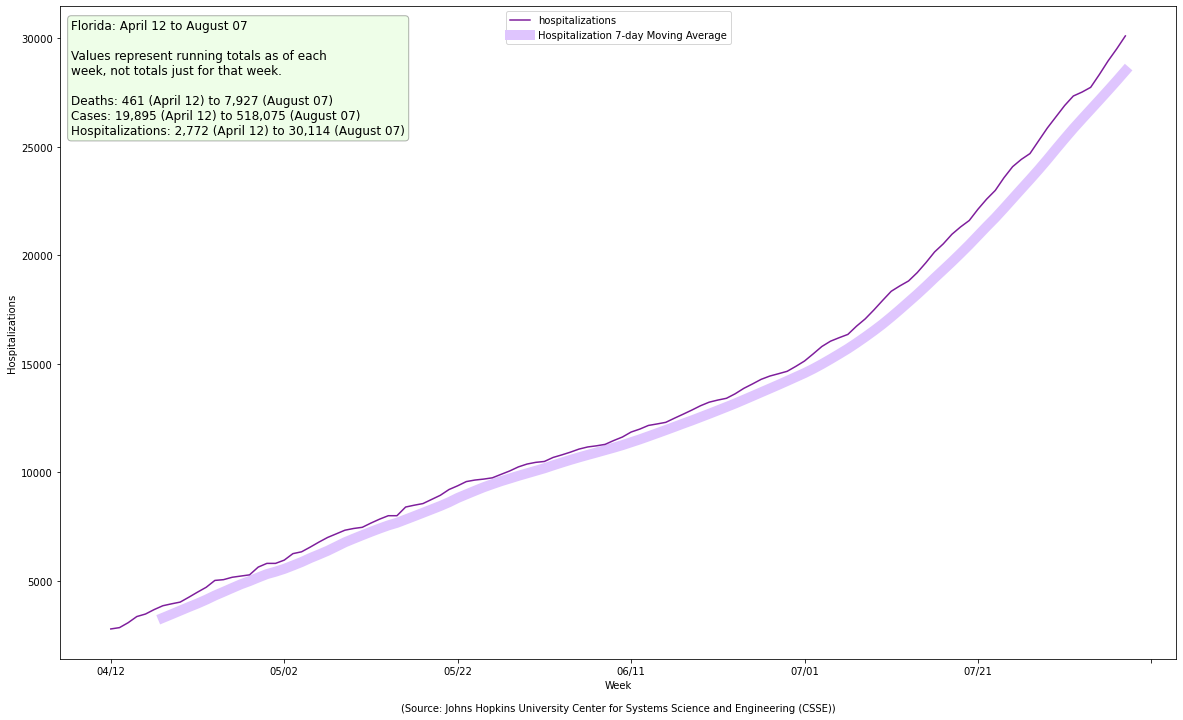

In [57]:
plot_state(df, SOURCE, 'Florida', image_file='jhu-fl-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

### South Carolina

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50128f6a0>)

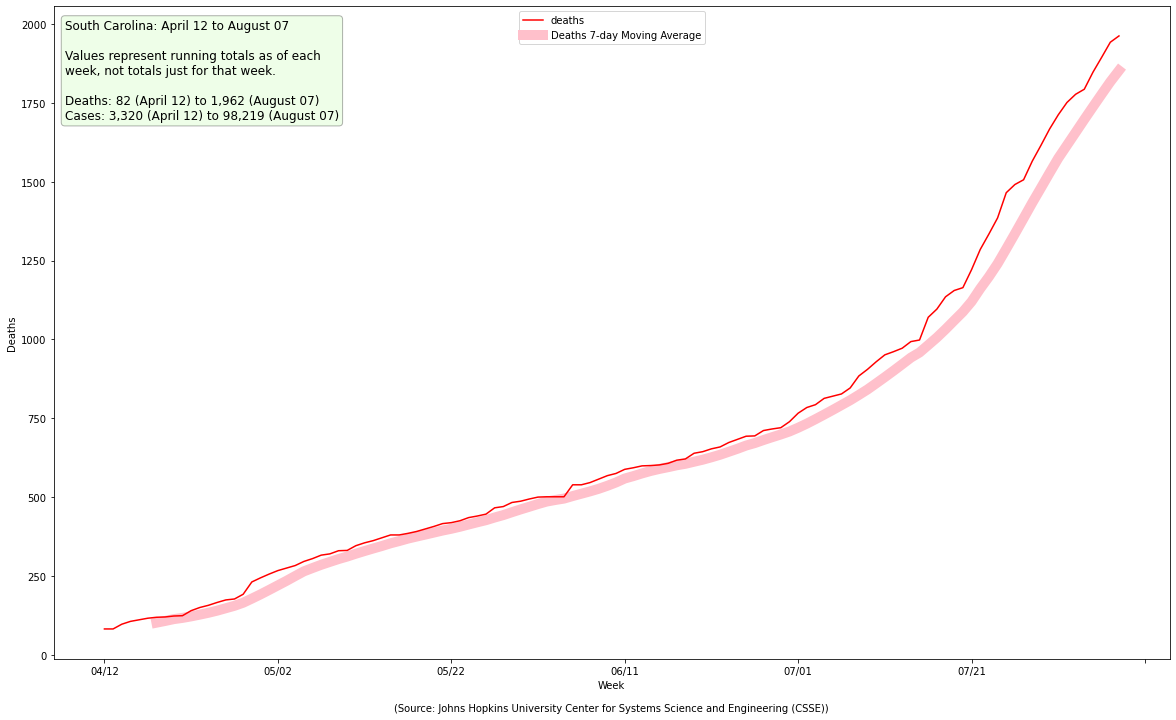

In [58]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5011fcd90>)

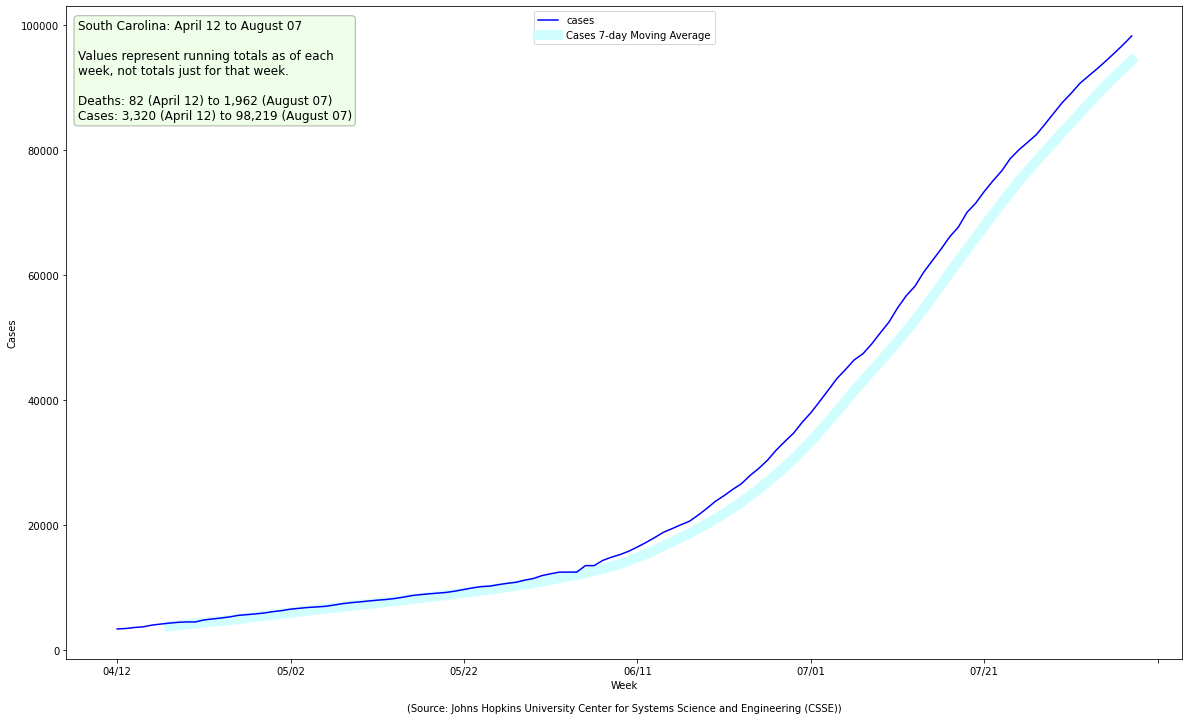

In [59]:
plot_state(df, SOURCE, 'South Carolina', image_file='jhu-sc-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc5011df850>)

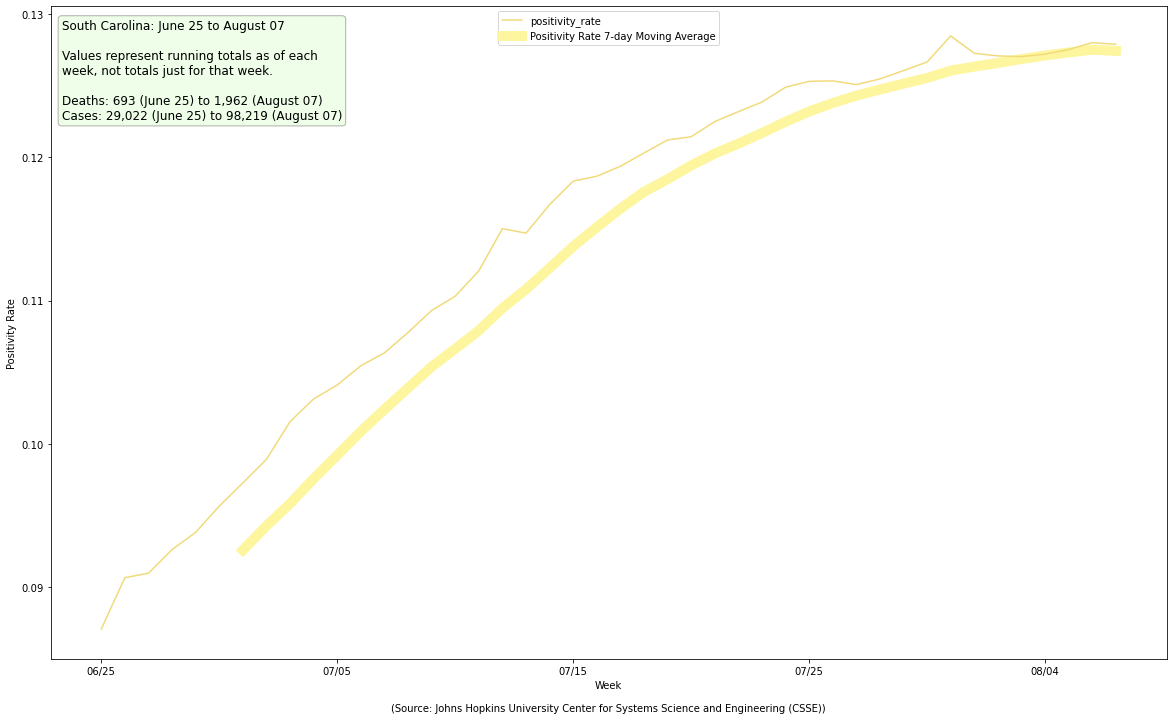

In [60]:
plot_state(df_positivity_dates, SOURCE, 'South Carolina', image_file='jhu-sc-pos.png',
           metrics={MetricType.POSITIVITY}, moving_average=True)

#### Oklahoma

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501191700>)

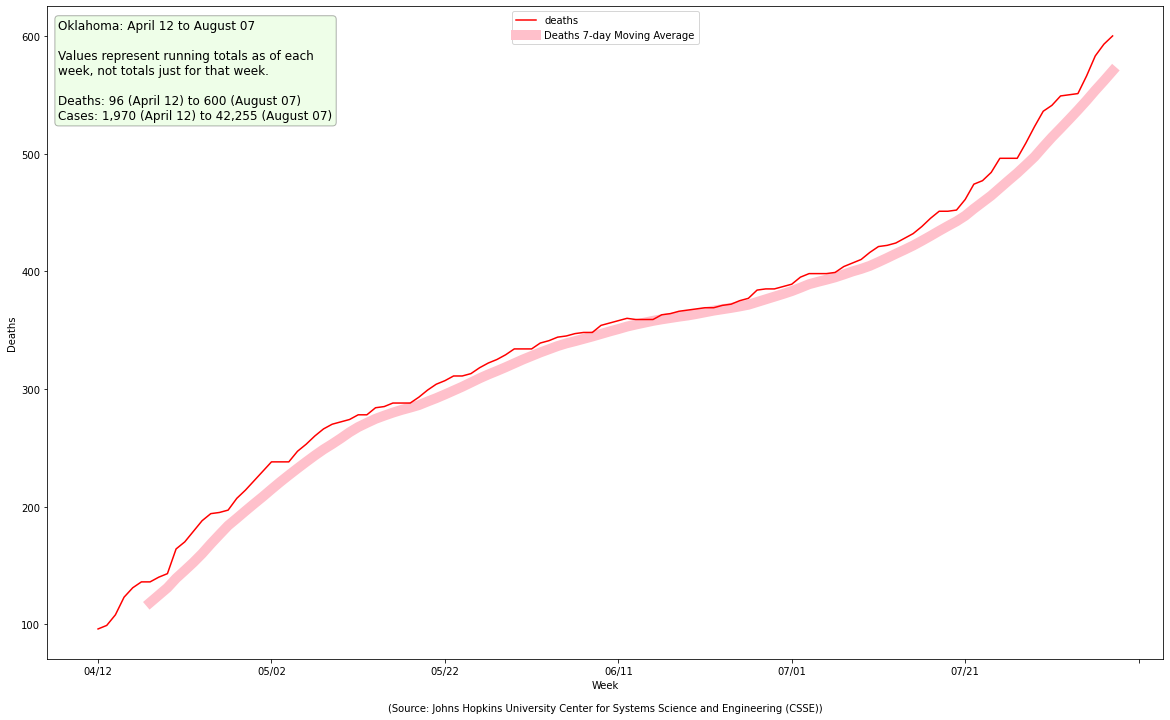

In [61]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-deaths.png', metrics={MetricType.DEATHS}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc501130190>)

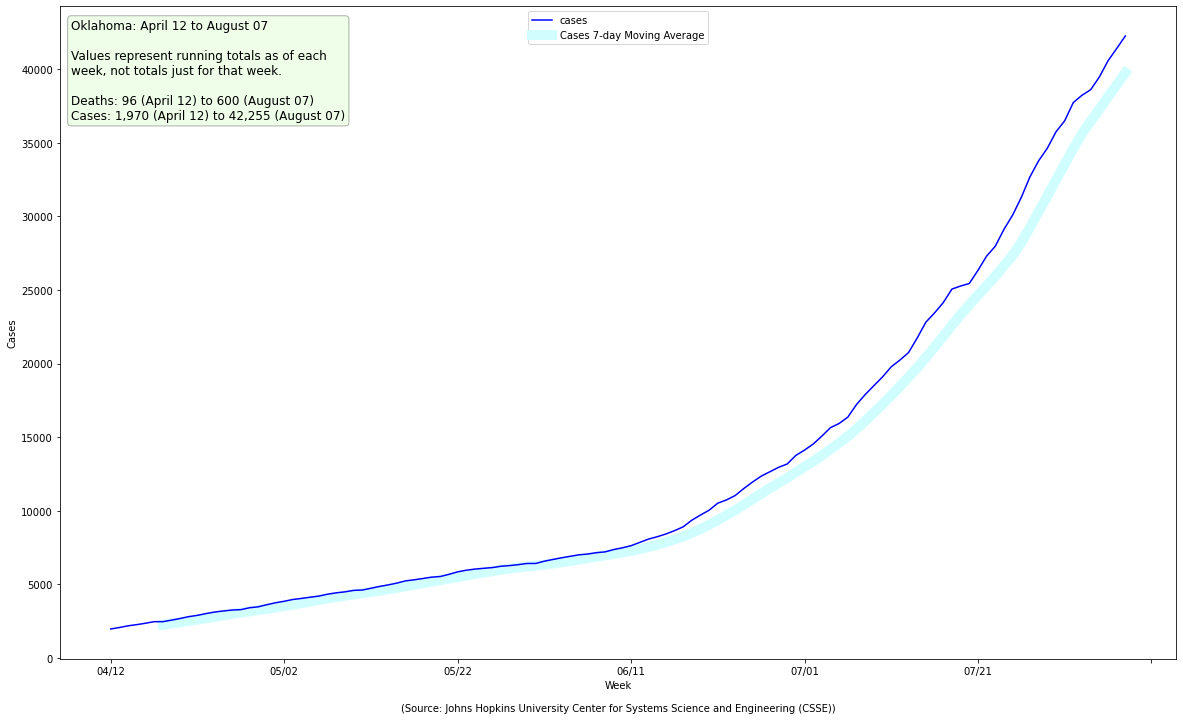

In [62]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-cases.png', metrics={MetricType.CASES}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50109de80>)

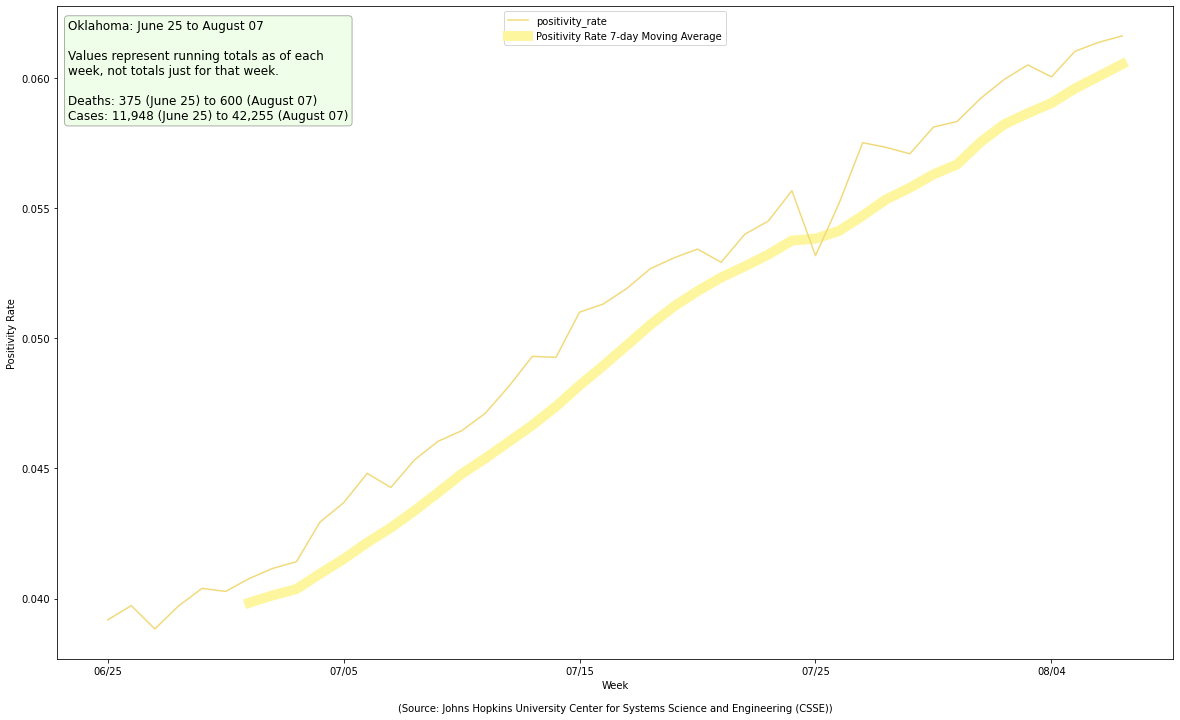

In [63]:
plot_state(df_positivity_dates, SOURCE, 'Oklahoma', image_file='jhu-ok-pos.png', 
           metrics={MetricType.POSITIVITY}, moving_average=True)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc50105b640>)

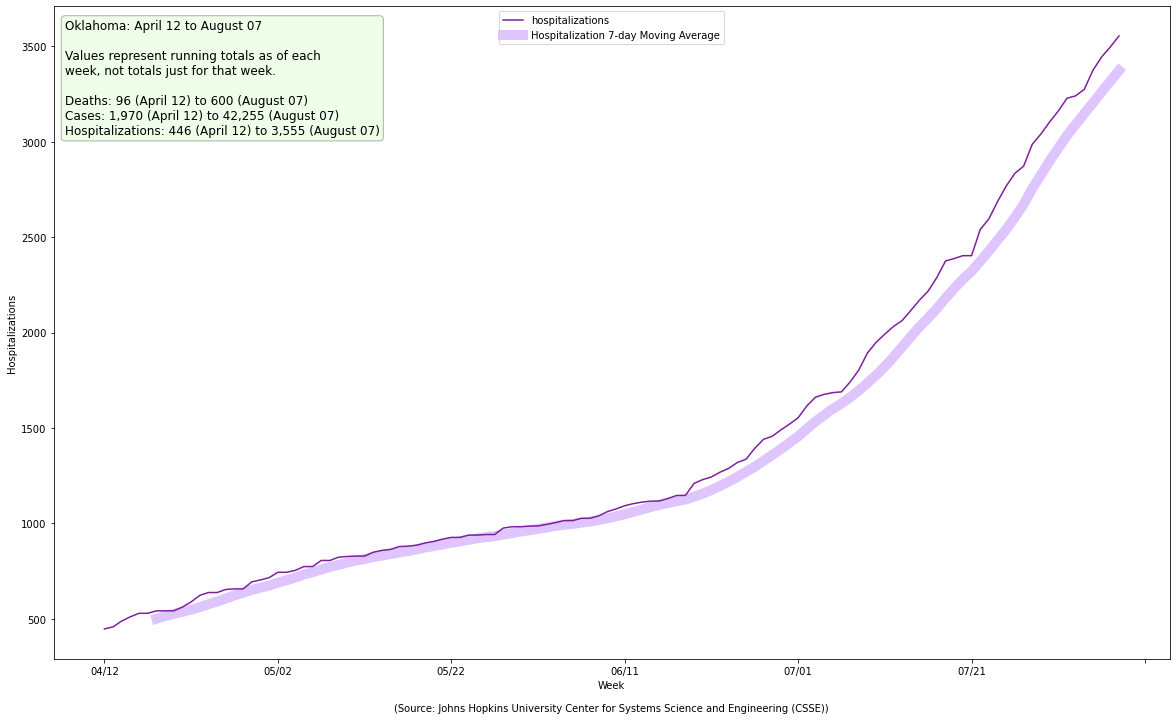

In [64]:
plot_state(df, SOURCE, 'Oklahoma', image_file='jhu-ok-hosp.png', metrics={MetricType.HOSPITALIZATIONS}, moving_average=True)

## Multistate

### Northeast states

Data from some of the states that were hardest hit early on.

In [65]:
ne_states = ('Connecticut', 'New York', 'New Jersey', 'Pennsylvania', 'Delaware', 'Ohio')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc500fdfb80>)

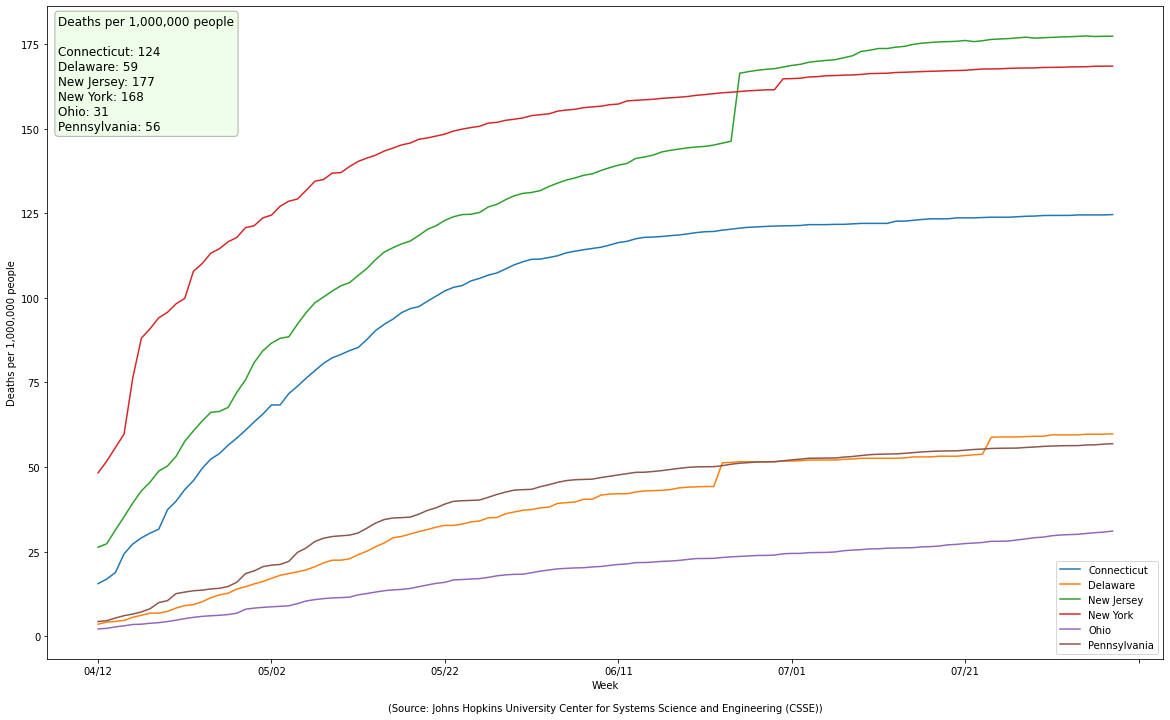

In [66]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.DEATHS,
            image_file='jhu-ne-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc500f46eb0>)

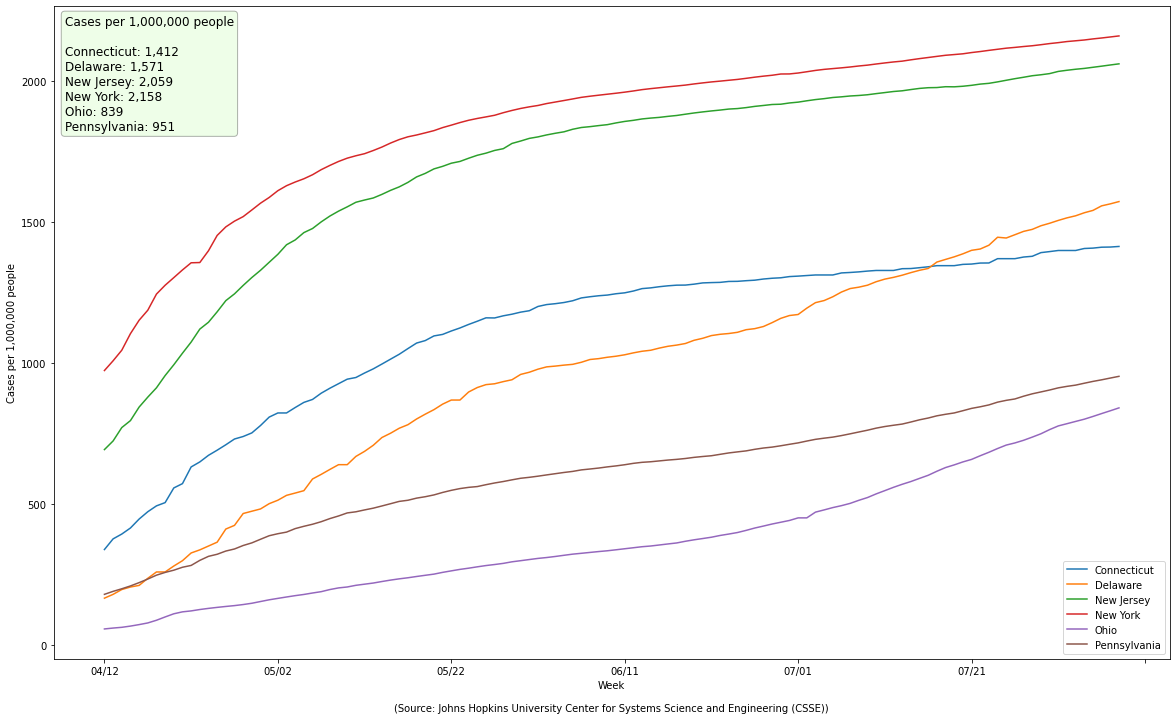

In [67]:
plot_states(df, SOURCE, ne_states, per_n=1_000_000, populations=populations, metric=MetricType.CASES,
            image_file='jhu-ne-states-cases-per-capita.png')

### South and southwestern states

Data from some of the states hard hit in mid-2020.

In [68]:
s_sw_states = ('Arizona', 'Texas', 'Oklahoma', 'South Carolina', 'Utah', 'California', 'Florida')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc500ec4700>)

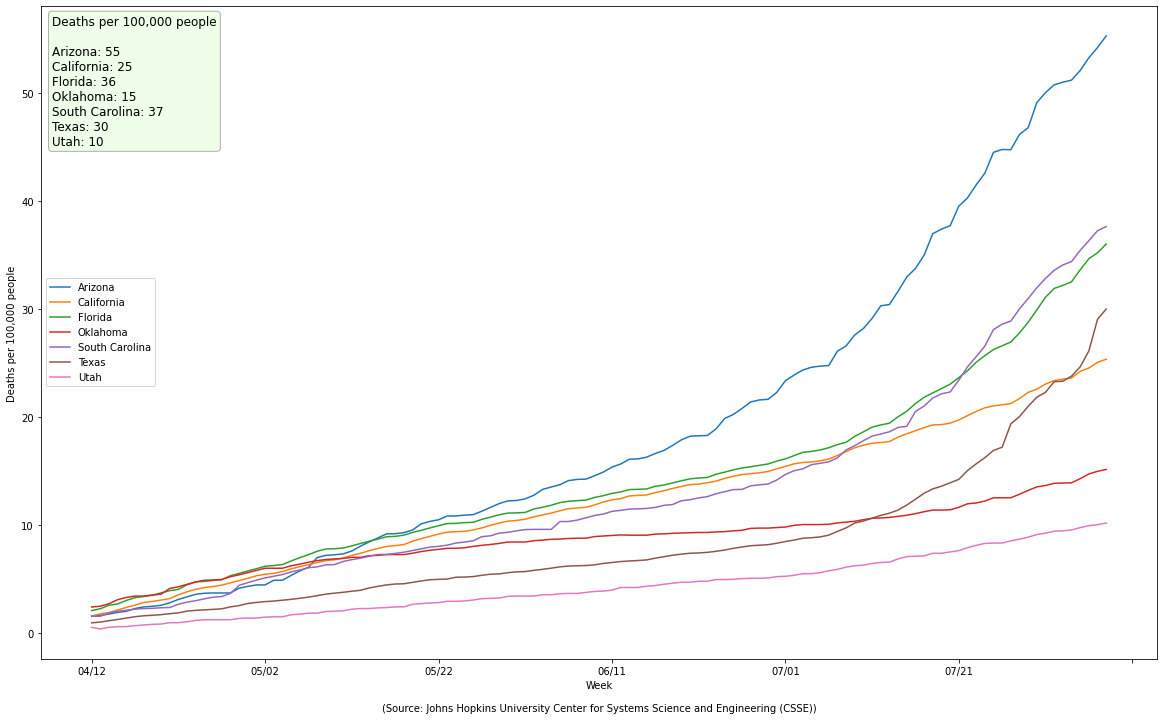

In [69]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.DEATHS,
            legend_loc='center left', image_file='jhu-s-sw-states-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc500e507f0>)

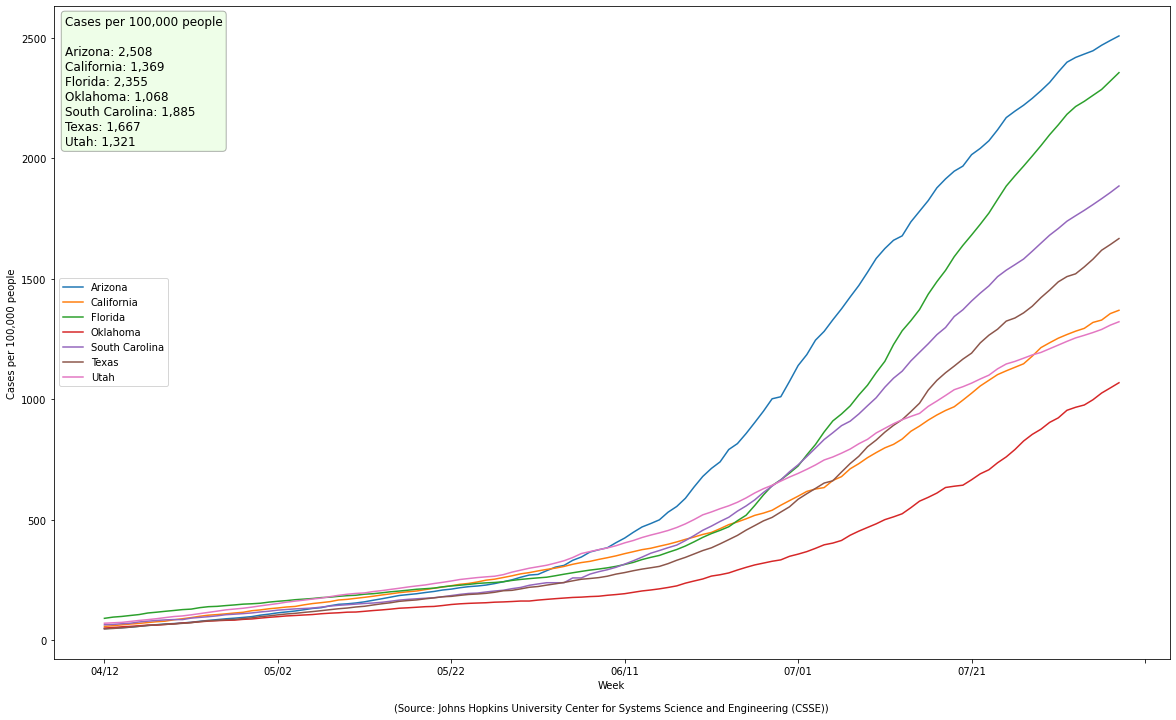

In [70]:
plot_states(df, SOURCE, s_sw_states, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-cases-per-capita.png')

How are some of these states doing, compared to Pennsylvania (my home state)?

In [71]:
s_sw_plus_pa = s_sw_states + ('Pennsylvania',)

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc500e57160>)

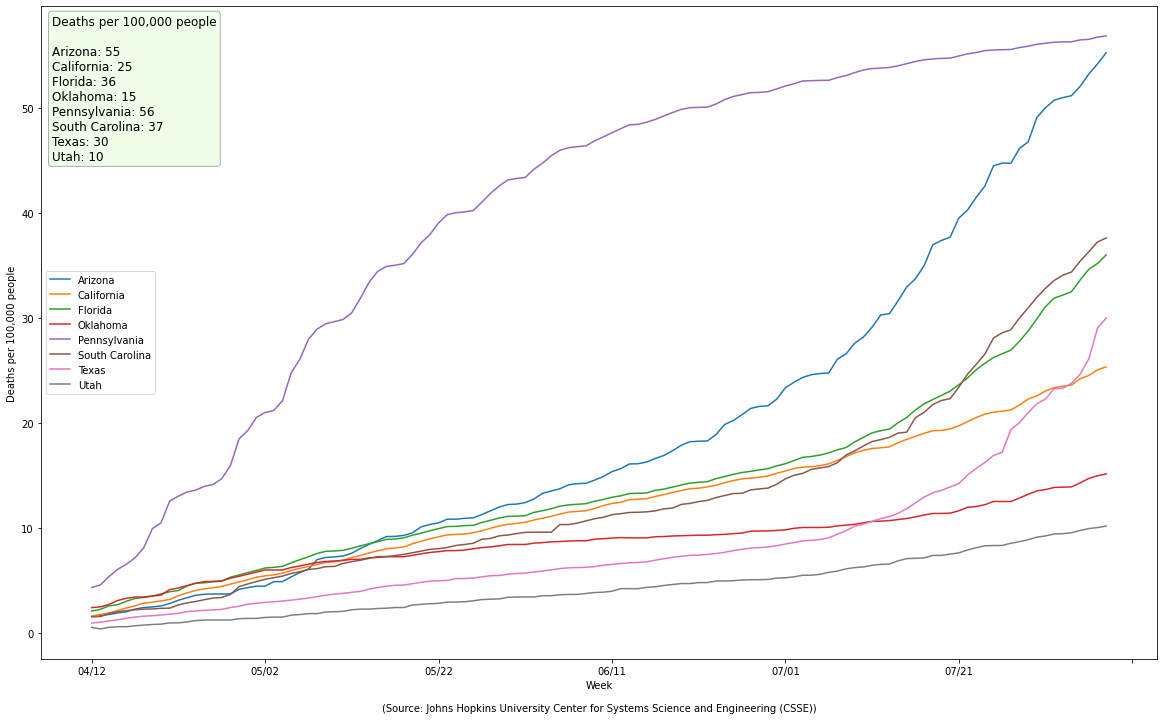

In [72]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.DEATHS, 
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-deaths-per-capita.png')

(<Figure size 1440x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc500d75190>)

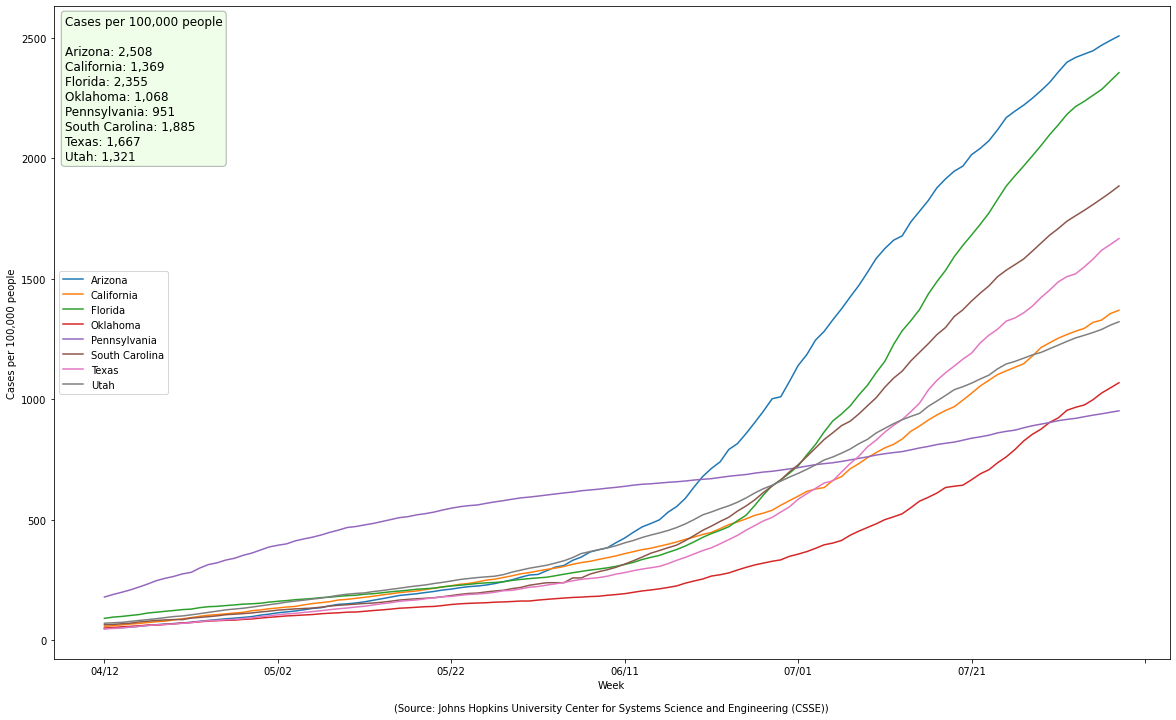

In [73]:
plot_states(df, SOURCE, s_sw_plus_pa, per_n=100_000, populations=populations, metric=MetricType.CASES,
            legend_loc='center left', image_file='jhu-s-sw-states-with-pa-cases-per-capita.png')

## Per-capita rates for all states

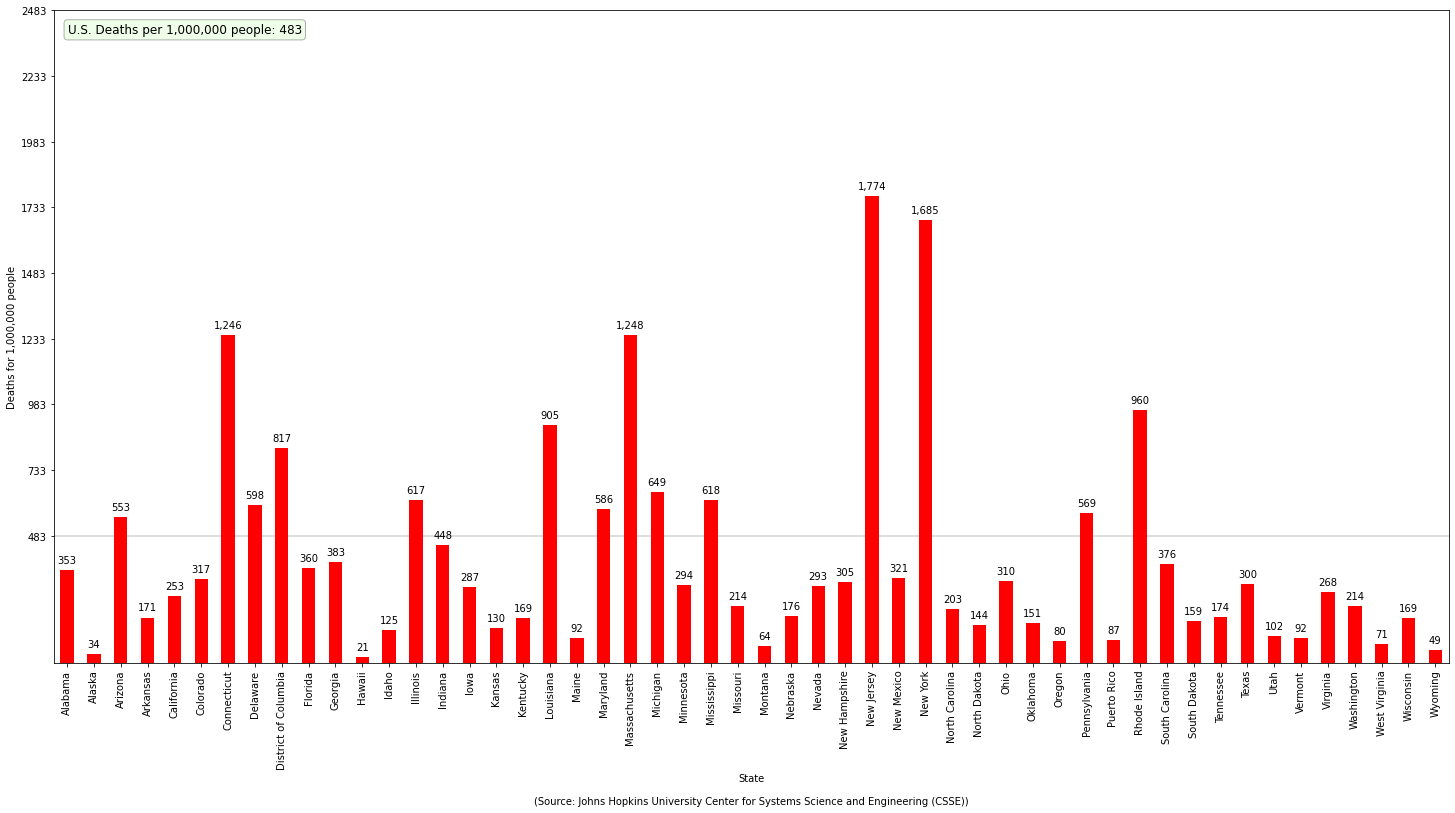

In [74]:
plot_states_per_capita(df, SOURCE, populations, image_file='jhu-state-deaths-per-capita.png');

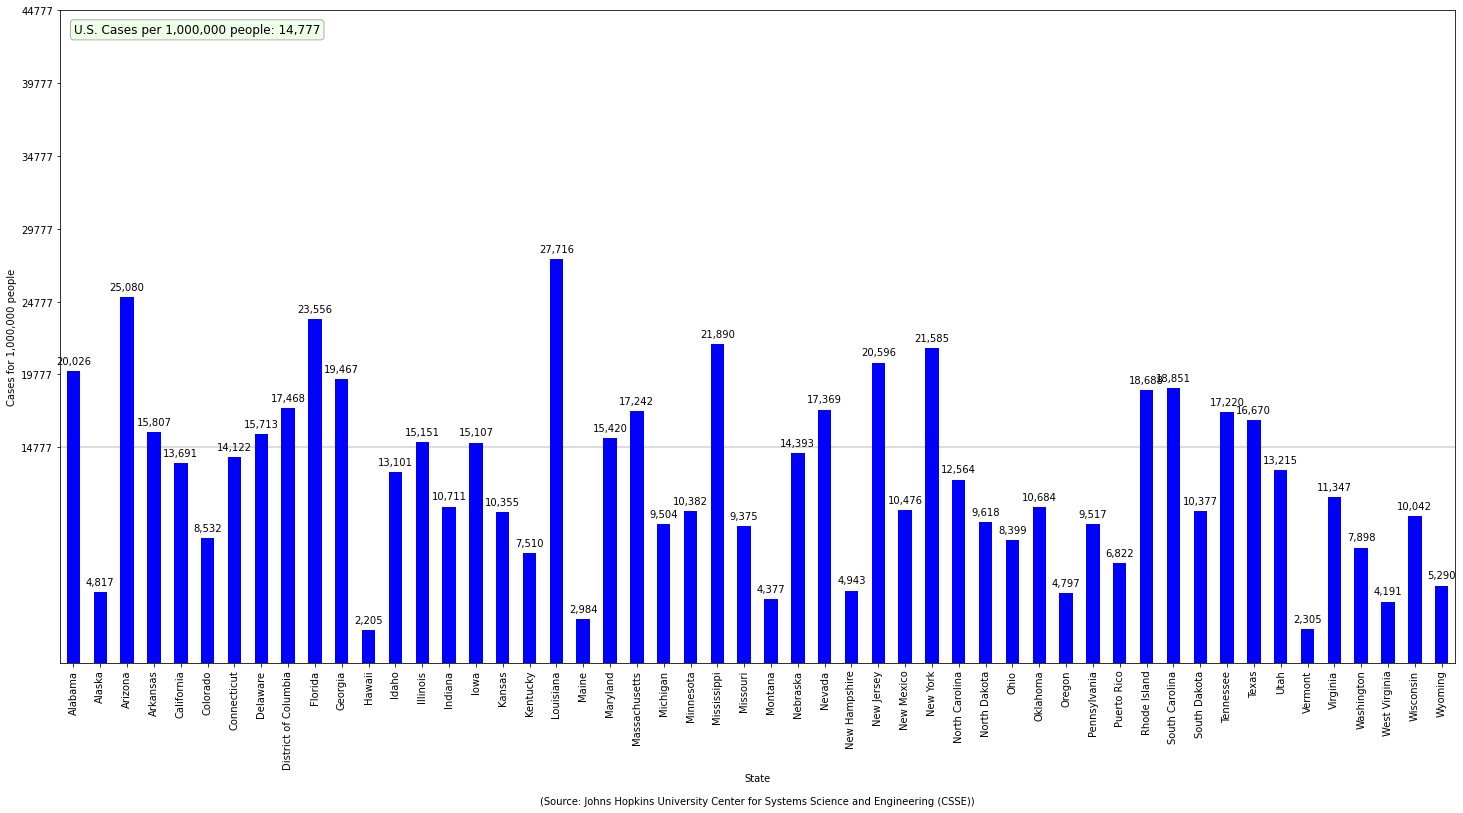

In [75]:
plot_states_per_capita(df, SOURCE, populations, metric=MetricType.CASES, image_file='jhu-state-cases-per-capita.png');